# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('ggplot')

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [12, 5],
   }

plt.rcParams.update(params)

import pandas as pd
import numpy as np
from numpy import percentile
np.random.seed(42)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge
from sklearn.compose import TransformedTargetRegressor

from scipy.stats import skew

import re
from tqdm.notebook import tqdm

pd.options.display.max_rows = 500

import calendar
MONTH_NAMES = [calendar.month_name[x][:3] for x in range(1,13)]

In [2]:
# # Print Pandas version and dependencies for reproducability
# print("Pandas version and dependencies")
# print(pd.__version__)
# print(pd.show_versions())

# Ames Housing Data Set

## Introduction 
---

The [Ames Housing Data Set](http://jse.amstat.org/v19n3/decock.pdf) is a modern alternative to the well-known [Boston Housing Data Set from 1978](https://www.kaggle.com/c/boston-housing). Until recently, the Boston data set was intensively used in course material, education and tutorials. However, the data contains ethical problems and further use is discouraged with good reason. See [this article for more details](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

The Ames Housing Data Set was collected by [Dean De Cock](https://www.linkedin.com/in/dean-de-cock-b5336537), Professor of Statistics at Truman State University, in 2011. The dataset contains **information about individual residential properties in [Ames, Iowa](https://en.wikipedia.org/wiki/Ames,_Iowa) from 2006 to 2010**. 

>*«The original data (obtained directly from the Ames Assessor's Office) is used for tax assessment purposes but lends itself directly to the prediction of home selling prices. The type of information contained in the data is similar to what a typical home buyer would want to know before making a purchase»*

The full dataset consists of 2930 samples with 82 variables. In this task I'll **work on a subset of 2'430 observations (for training)** and **500 observations for which I want to predict the sale prices** (the test set). 

---
    
Dean De Cock created the dataset for his students as a final project in an undergraduate regression course. De Cock's [detailed description](http://jse.amstat.org/v19n3/decock.pdf) already gives a lot of useful information and hints. In addition we have the data documentation which [can also be downloaded from here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

We get for example these details about the data:
* **82 variables in total**: 23 nominal, 23 ordinal, 14 discrete and 20 continuous
* **20 continuous** variables relate to various area dimensions (e.g. lot size, total dwelling square footage etc.)
* **14 discrete** variables quantify the number of architectural features of the house (e.g. kitchens, baths, etc.)
* **46 categorical** variables, ranging from 2 to 28 classes (e.g. smallest STREET, largest NEIGHBORHOOD)

With the **Parcel Identification Number (PID)** we can get [very detailed additional information for every property via this link](https://beacon.schneidercorp.com/). This e.g. is a [sample query for PID 0526301100](https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&Q=1309077508&KeyValue=0526301100)

---
    
Dean De Cock **warns us about outliers** in the data description:

>*There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don't represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.*
        

## Goal of this project
---
**My goal is to prepare, clean, encode and explore the data. Then I'd like to fit models of different sizes, compare these and communicate the results.**

# A first look at the data
---

In [3]:
df = pd.read_csv("_data/house-prices.csv")
df_test = pd.read_csv("_data/house-prices-test.csv")

# For the EDA I concatenate the train and test set while keeping in mind 
# that I am not supposed to derive knowledge from the test data to avoid data leakage
df = pd.concat([df, df_test])
df.reset_index(drop=True, inplace=True)

- With **8MB of memory consumption** this dataset is small.
- As expected, Pandas recognizes **2'930 samples** and **82 features** in total.

In [4]:
print(f"There are {len(df) :,.0f} observations and {len(df.columns)} features in total.\n")

There are 2,930 observations and 82 features in total.



There is a **logical order in the columns**. The features go **from general to detail** and describe the **outside first** (e.g. Zoning, Street, Lot Area), then **the inside going from basement and floors to functional rooms and areas.** Finally we get information about the sale. 

In [5]:
display(df.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

None

In [6]:
display(pd.concat([df.head(3), df.tail(3)]))

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000.0
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000.0
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000.0
2927,350,527127100,120,RL,28.0,7296,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,NaN
2928,821,906340120,20,RL,61.0,10226,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,1,2009,WD,Normal,NaN
2929,2005,902427180,80,RM,76.0,11800,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,NaN


**Several features have missing values**, four of them over 80% (rounded).

In [7]:
missing = [(c, df[c].isna().mean()*100) for c in df]
missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
missing = missing[missing.percentage > 0]
display(missing.sort_values("percentage", ascending=False))

,column_name,percentage
73,Pool QC,99.556314
75,Misc Feature,96.382253
7,Alley,93.242321
74,Fence,80.477816
58,Fireplace Qu,48.532423
81,SalePrice,17.064846
4,Lot Frontage,16.723549
65,Garage Cond,5.426621
64,Garage Qual,5.426621
61,Garage Finish,5.426621


We have **no exact duplicates in the training data**.

In [8]:
print(f'There are {df.drop(["Order", "PID"], axis=1).duplicated().sum()} exact duplicate rows in the dataset.')

There are 0 exact duplicate rows in the dataset.


From printing a couple of random values and the `min()` and `max()` value from all data columns I see that I **need to properly encode a lot of categorical features** (binary, ordinal, one hot) and **convert some categoricals to numerical** because they aren't categorical or are more appropriately considered as quantitative data.

In [9]:
# n = 10
# # omitting Order and PID
# for feature in df.columns[2:]:
#     tmp = df[df[feature].notnull()]
#     print(feature, "|", tmp[feature].dtype)
#     print(tmp[feature].sample(n).values)
#     print(tmp[feature].min(), tmp[feature].max())
#     print()

By plotting a value count for each **categorical feature** I see that: 
- **almost all distributions are skewed** toward one or a few labels
- **some labels are very rare**, e.g. `Utilities` consists of three labels with two of them with a total count of only 3 samples

In [10]:
# df_obj = df.select_dtypes("object")

# for feature in df_obj.columns:
#     print("-"*72)
#     print(feature)
#     tmp = df_obj[feature].value_counts()
#     tmp.plot(kind="bar", title=feature, figsize=(12,3))
#     display(tmp.to_frame().T)
#     plt.xticks(rotation=0)
#     plt.tight_layout()
#     plt.show()
#     print()

By plotting the skewness, `min()` / `max()` again together with the value distribution of the **numerical features** I see that:
- **a lot of the features are heavily skewed**
- **the target variable `SalePrice` is not normally distributed** either
- many features have **many outliers**
- **some features have to be erroneous**: e.g. the max value for `Garage Yr Blt` is `2207`, the mayority of houses have `1950` as `Year Remod/Add`
- **a lot of values are 0** which seem to indicate a missing item in the house rather than an actual value of 0 e.g., `Mas Vnr Area`, `BsmtFin SF 1` etc.

In [11]:
# df_num = df.drop(["Order", "PID"], axis=1).select_dtypes("number")

# for feature in df_num.columns:
#     print("-"*72)
#     print(feature)
#     print(f"min: {df_num[feature].min()} | max: {df_num[feature].max()} | skewness: {df_num[feature].skew():.2f}")
#     plt.subplot(2,1,1)
#     df_num[feature].plot(kind="hist", bins=100, rwidth=.9, figsize=(12,5))
#     plt.ylabel("")
#     plt.subplot(2,1,2)
#     df_num[feature].plot(kind="box", vert=False)
#     plt.tight_layout()
#     plt.show()
#     print()

From **descriptive statistics** I notice:
- the **wide range of sale prices** from 12'789 to 755'000 USD
- the **wide range of lot area** from 1'470 to 215'245 sqft

I notice too that the range of `Yr Sold` is between 2006 and 2010. So I likely need to adjust the temporal features of the house to **the actual temporal value at the moment when the house was sold** to get a more precise feature, e.g. `Yr Sold - Year Built`

In [12]:
tmp = df.drop(["Order", "PID"], axis=1).select_dtypes("number")
with pd.option_context('display.float_format', '{:,.0f}'.format):
    display(tmp.describe().loc[["mean", "50%", "min", "max"]].T.iloc[1:])

,mean,50%,min,max
Lot Frontage,69,68,21,313
Lot Area,"10,148","9,436","1,300","215,245"
Overall Qual,6,6,1,10
Overall Cond,6,5,1,9
Year Built,"1,971","1,973","1,872","2,010"
Year Remod/Add,"1,984","1,993","1,950","2,010"
Mas Vnr Area,102,0,0,"1,600"
BsmtFin SF 1,443,370,0,"5,644"
BsmtFin SF 2,50,0,0,"1,526"
Bsmt Unf SF,559,466,0,"2,336"


In terms of **linear correlation to the target variable** several features stick out and will likely be useful for predicting the sale price:
- `Overall Qual` (material and finish of house), `Gr Liv Area` (living area above ground) are the most correlated
- `Total Bsmt SF`, `1st Flr SF` as well as `Garage Cars` and `Garage Area` are highly correlated as well (the USA is a very car-centric society after all 😉)
- the age of the house and garage (`Year Built`, `Garage Yr Blt`) as well as the time of last remodeling (`Year Remod/Add`) are likely candidates for useful features too 

In [13]:
corr = df.drop(["Order", "PID"], axis=1).corr()
# Set threshold to cut off weak correlations
correlation_treshold = 0.5

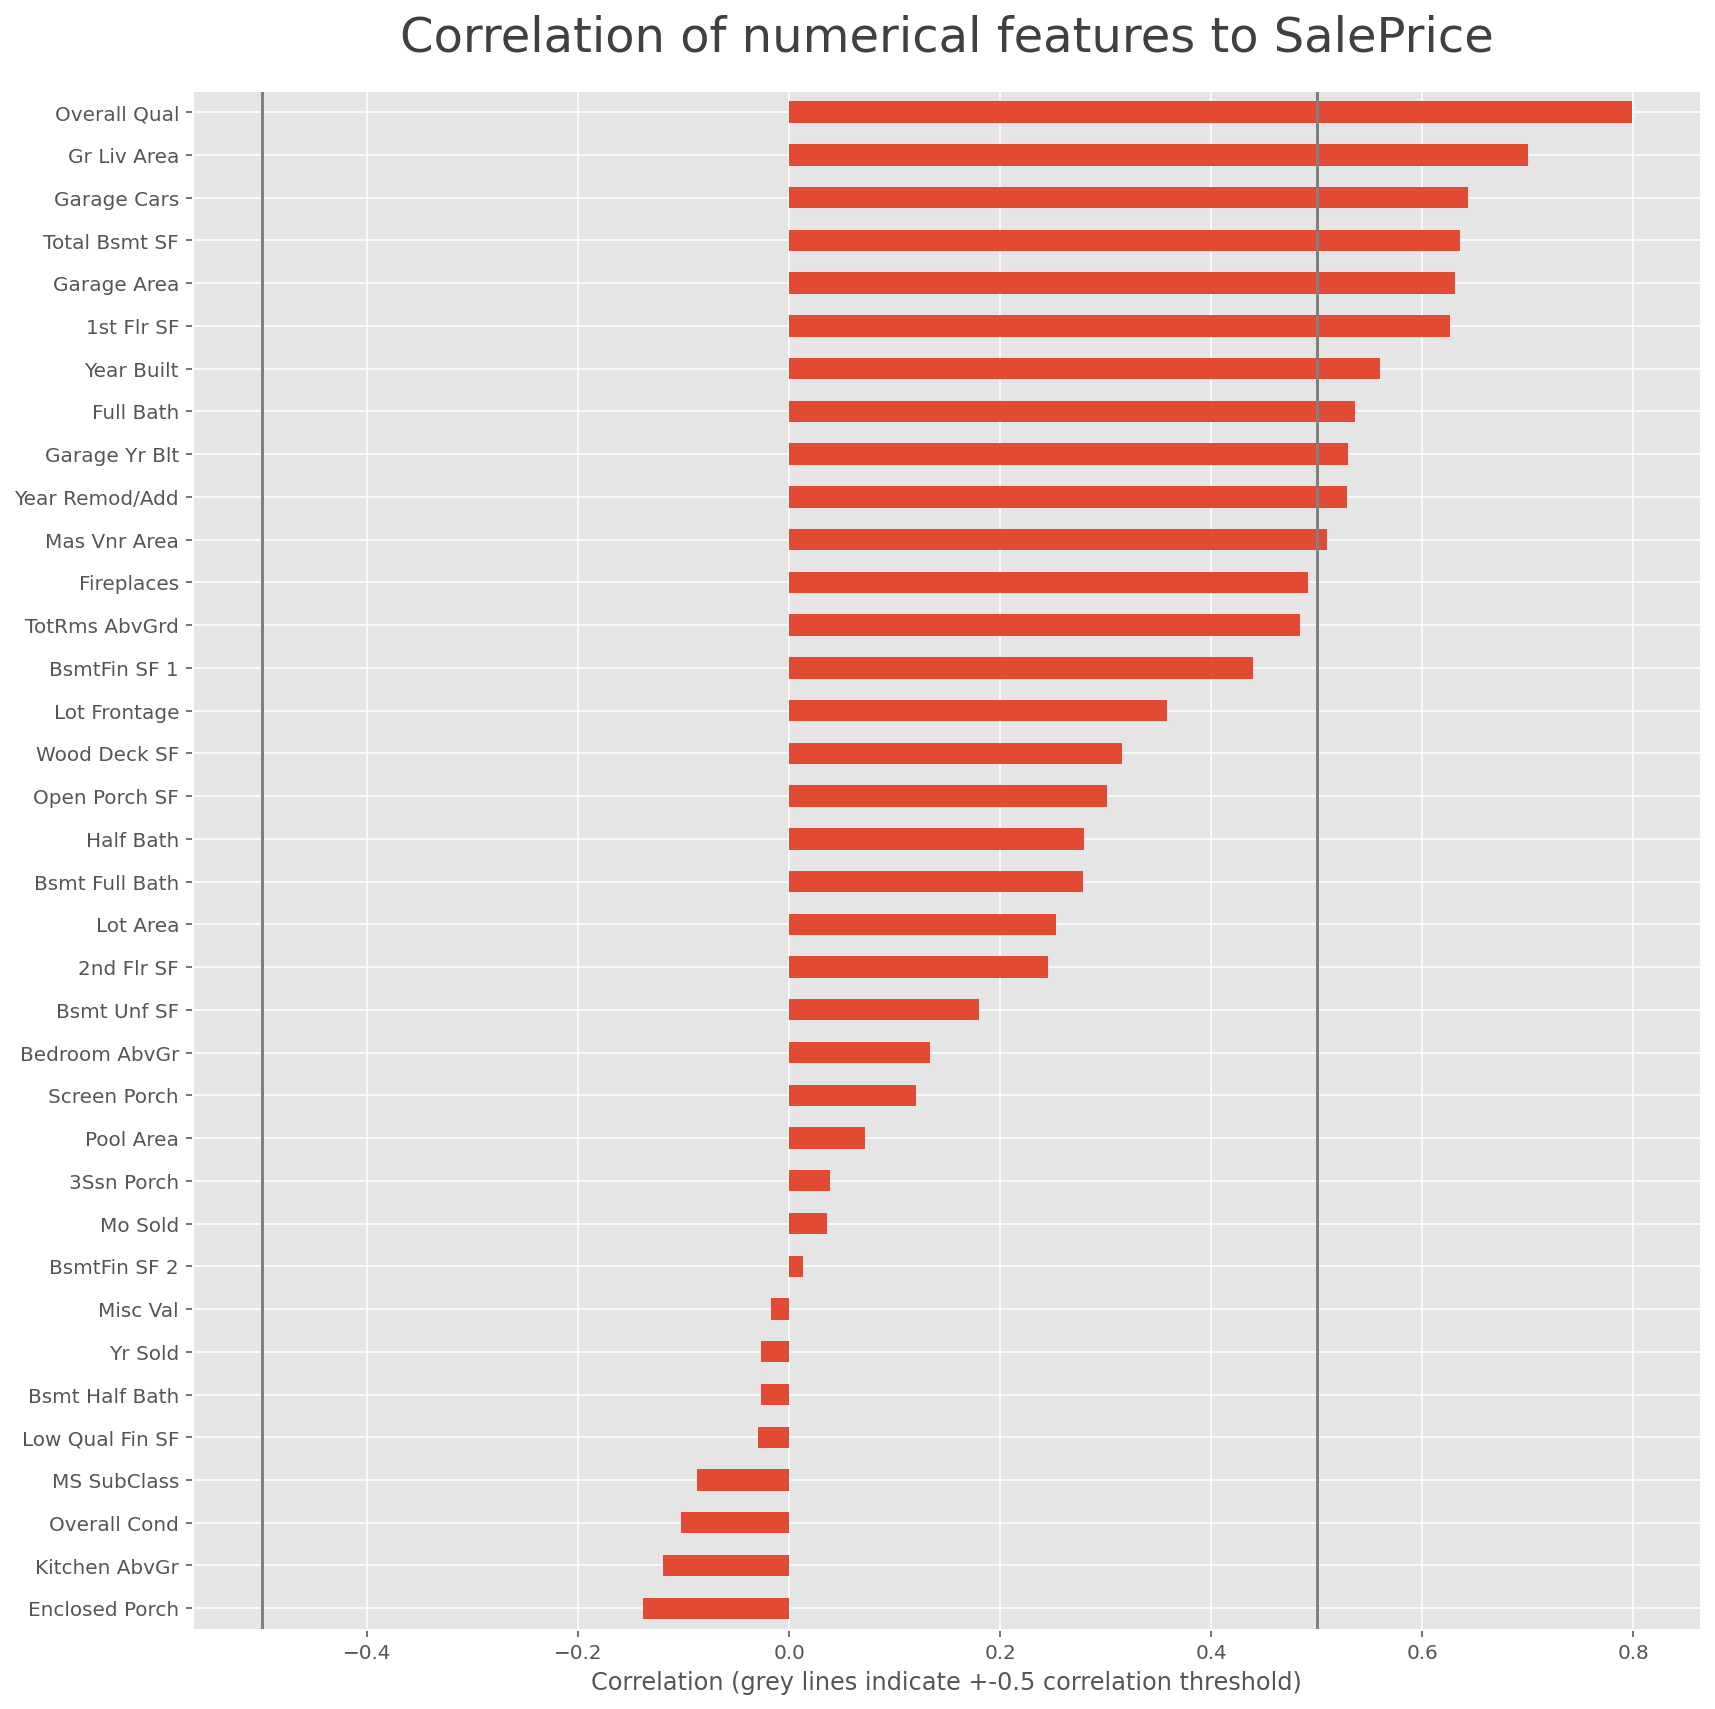

In [14]:
corr["SalePrice"].sort_values(ascending=True)[:-1].plot.barh(figsize=(12,12))
plt.title(f"Correlation of numerical features to SalePrice", size=24, pad=20)
plt.axvline(-correlation_treshold, color="grey")
plt.axvline(correlation_treshold, color="grey")
plt.xlabel(f"Correlation (grey lines indicate +-{correlation_treshold} correlation threshold)")
plt.tight_layout()
plt.show()

Scatterplotting the sale prices to the top 5 correlated features show the correlation – and outliers – in more detail. The plot also reveals possibly erroneous values, e.g. for `Total Bsmt SF` which can't possibly be zero.

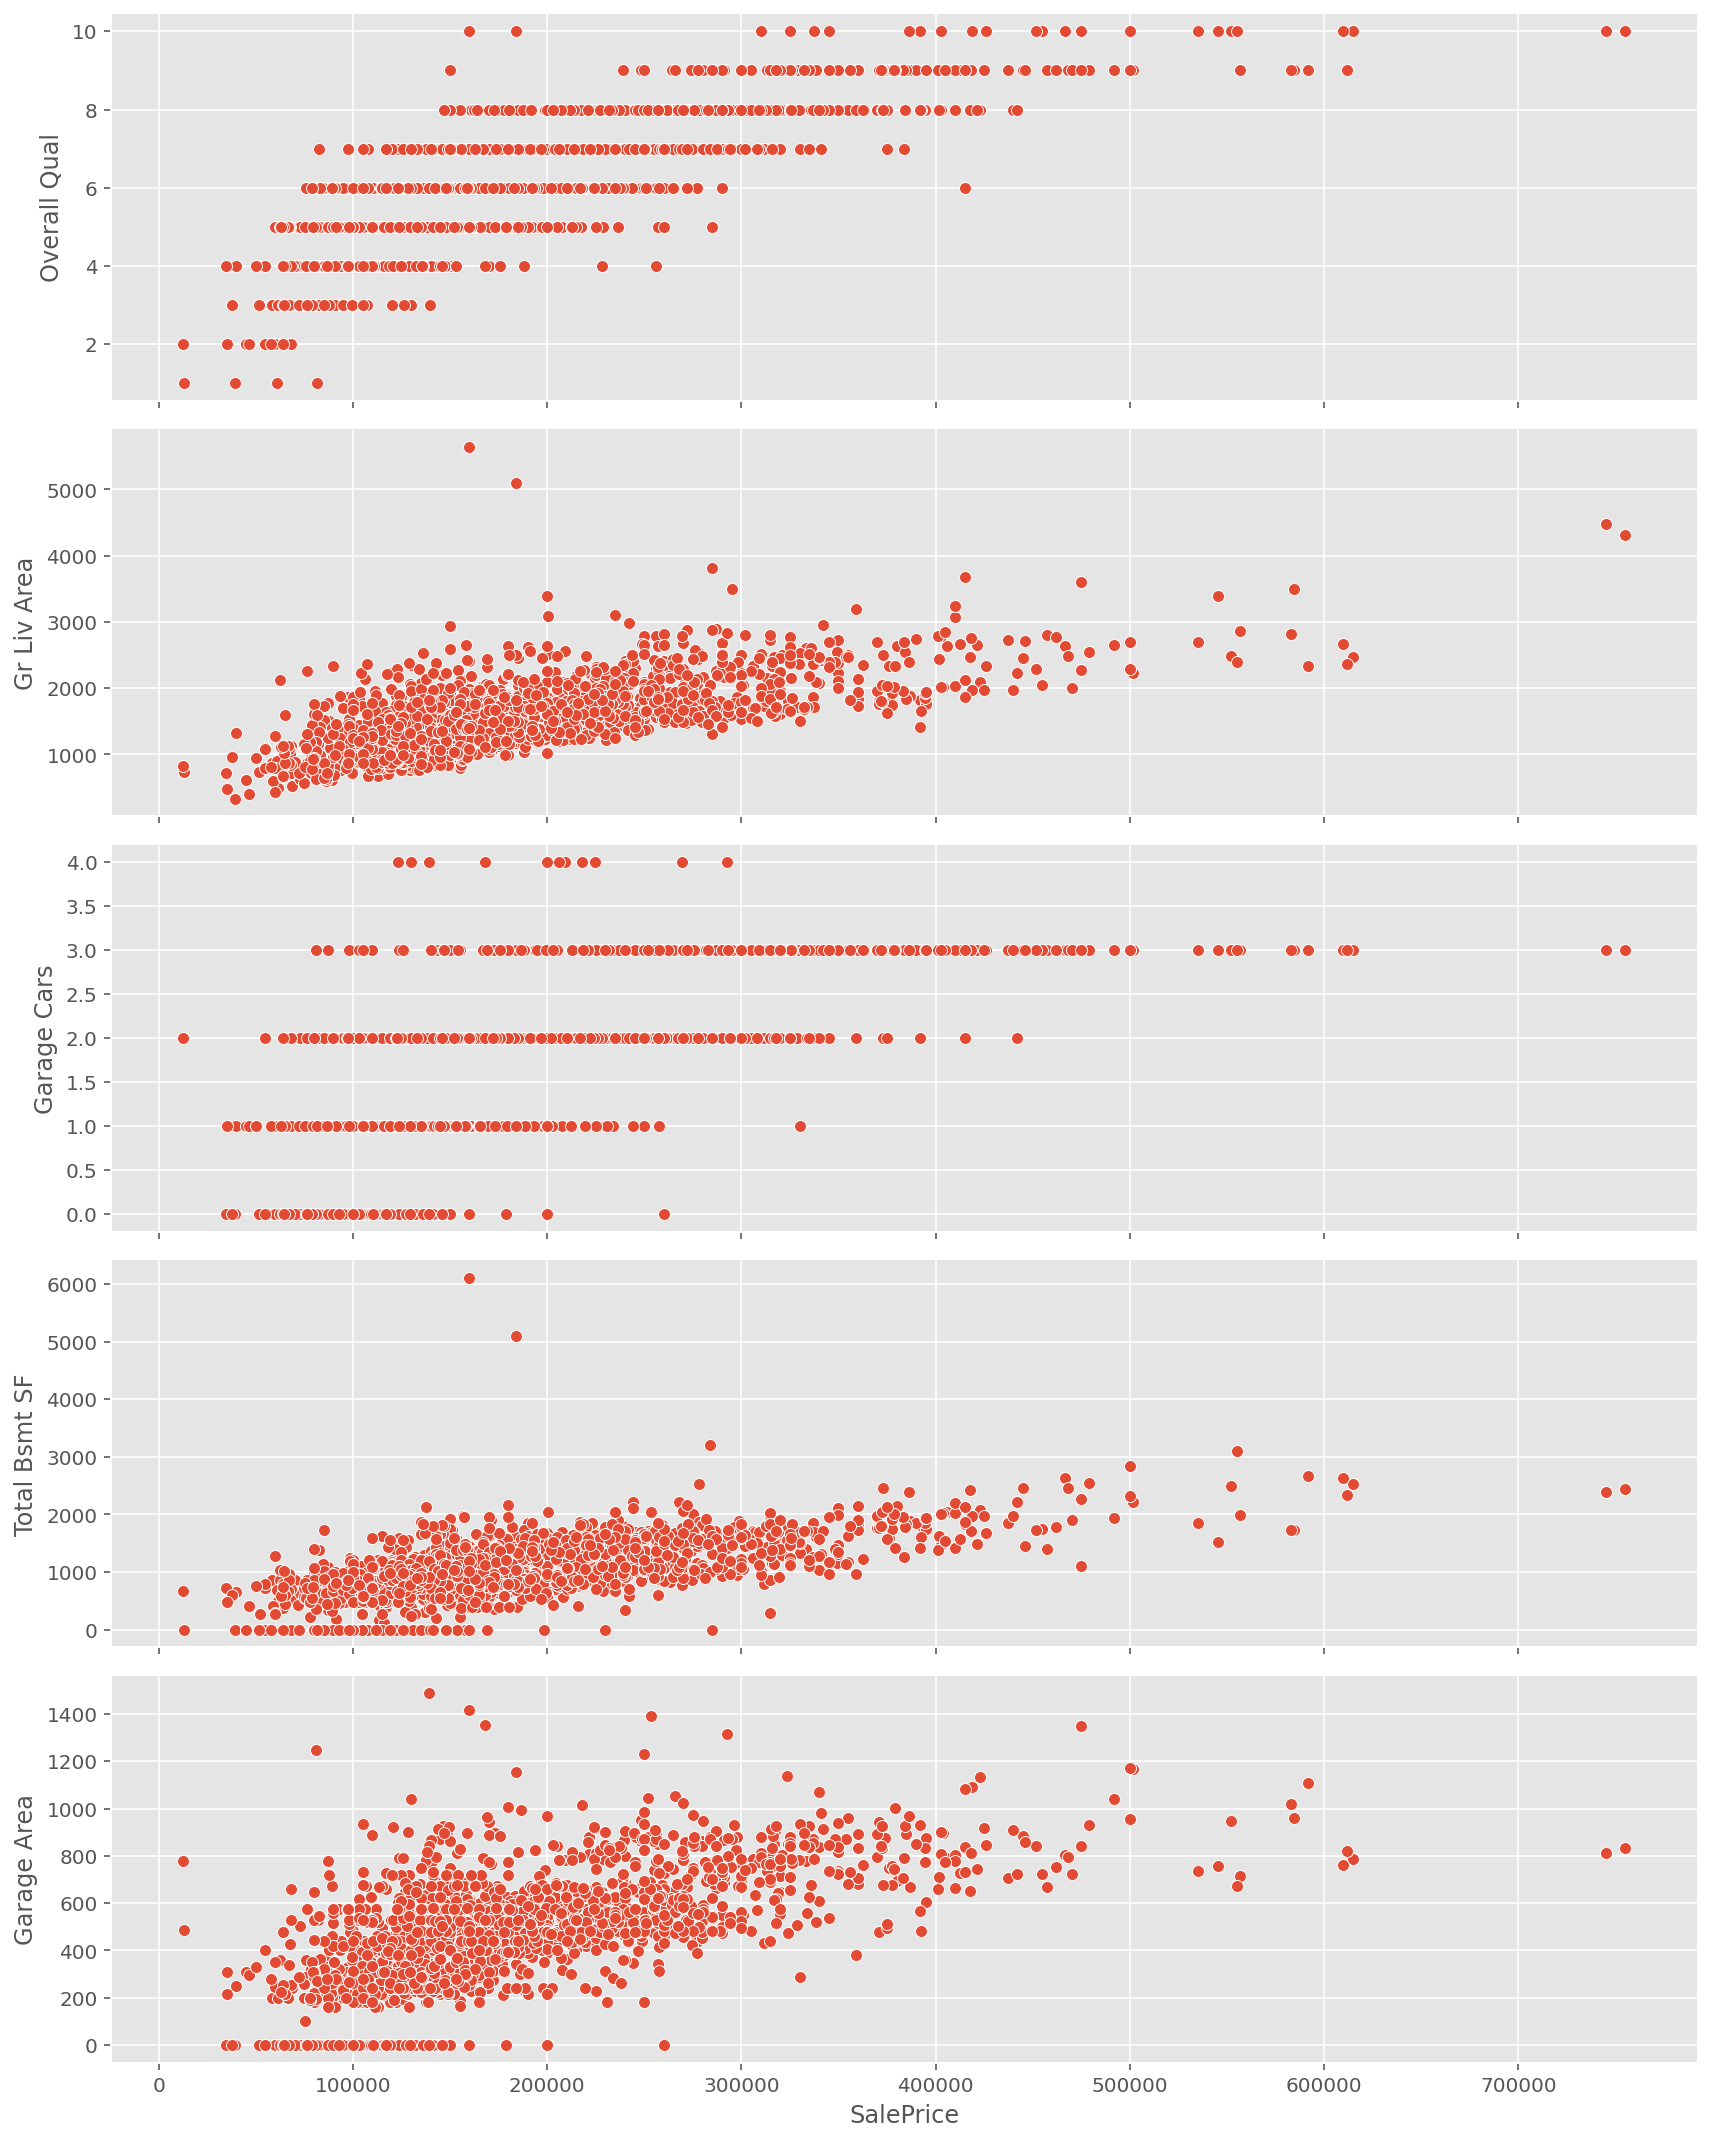

In [15]:
top_5 = corr["SalePrice"].sort_values(ascending=False)[1:6].index
sns.pairplot(data=df, x_vars="SalePrice", y_vars=top_5, height=3, aspect=4)
plt.tight_layout()
plt.show()

**Many features do not have a substantial correlation to the target variable and neither towards one another.** This insight can be helpful for discarding superfluous features.

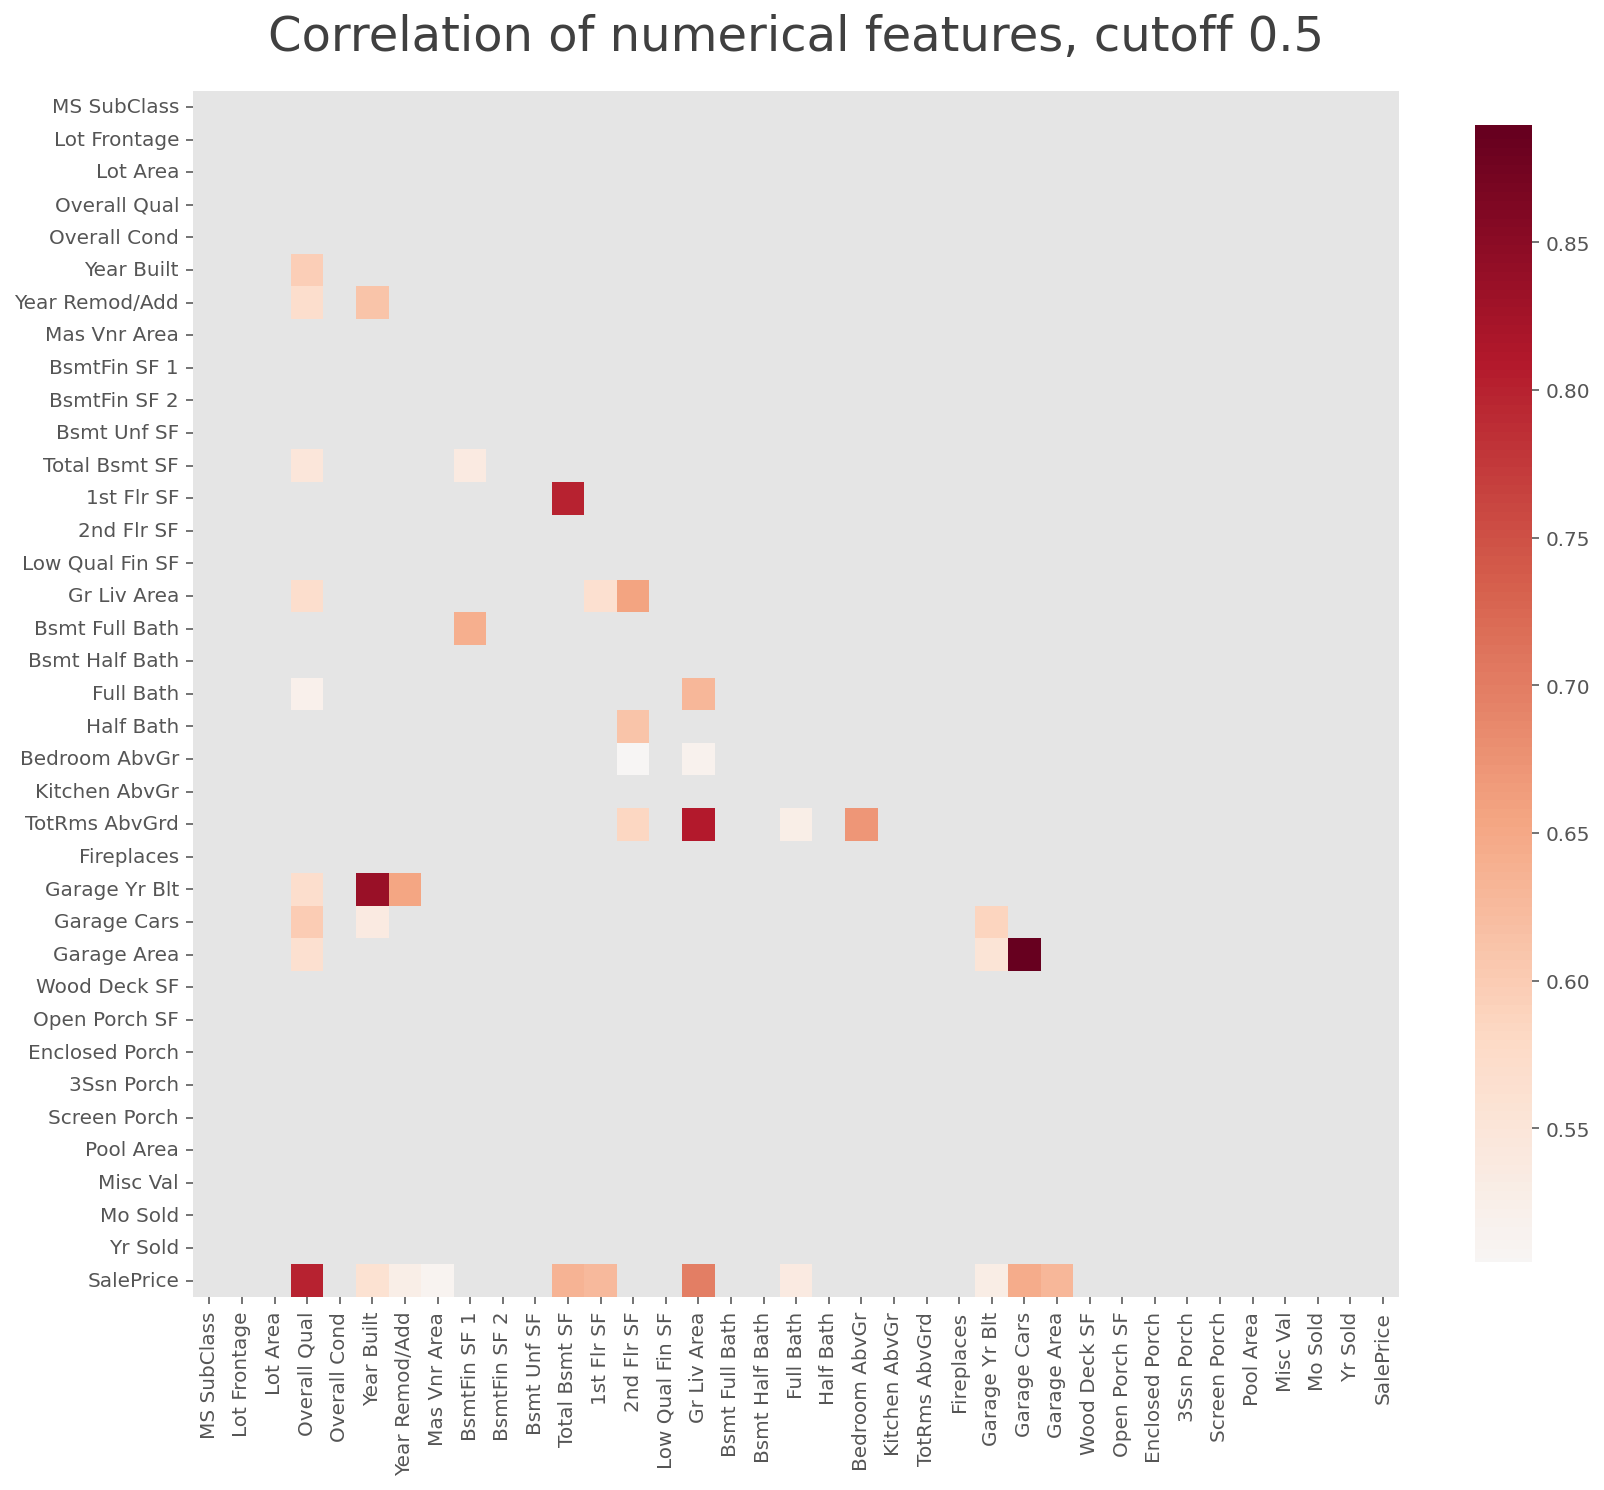

In [16]:
corr_cutoff = corr[(corr > correlation_treshold) | (corr < -correlation_treshold)]

plt.figure(figsize=(12,12))
sns.heatmap(corr_cutoff, 
            cmap="RdBu_r", 
            # https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap
            mask= np.triu(corr_cutoff),
            center=correlation_treshold,
            square=True, 
            annot=False, 
            cbar_kws={"shrink": .7},
           )

plt.title(f"Correlation of numerical features, cutoff {correlation_treshold}", size=24, pad=20)
plt.tight_layout()
plt.show()

We already have seen **the skewed distribution of SalePrice**. It might be a sensible idea to **log transform the target**.

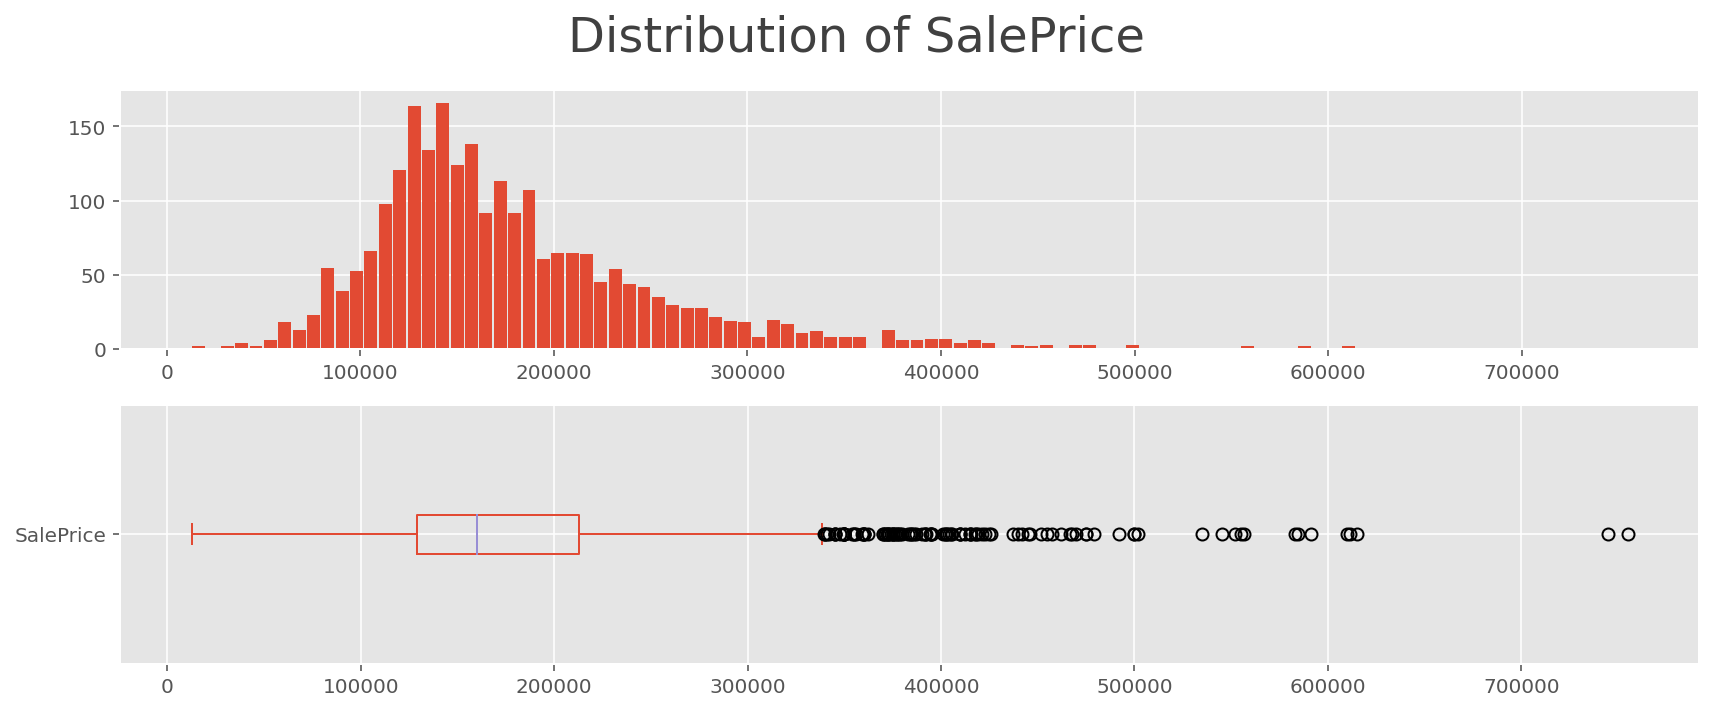

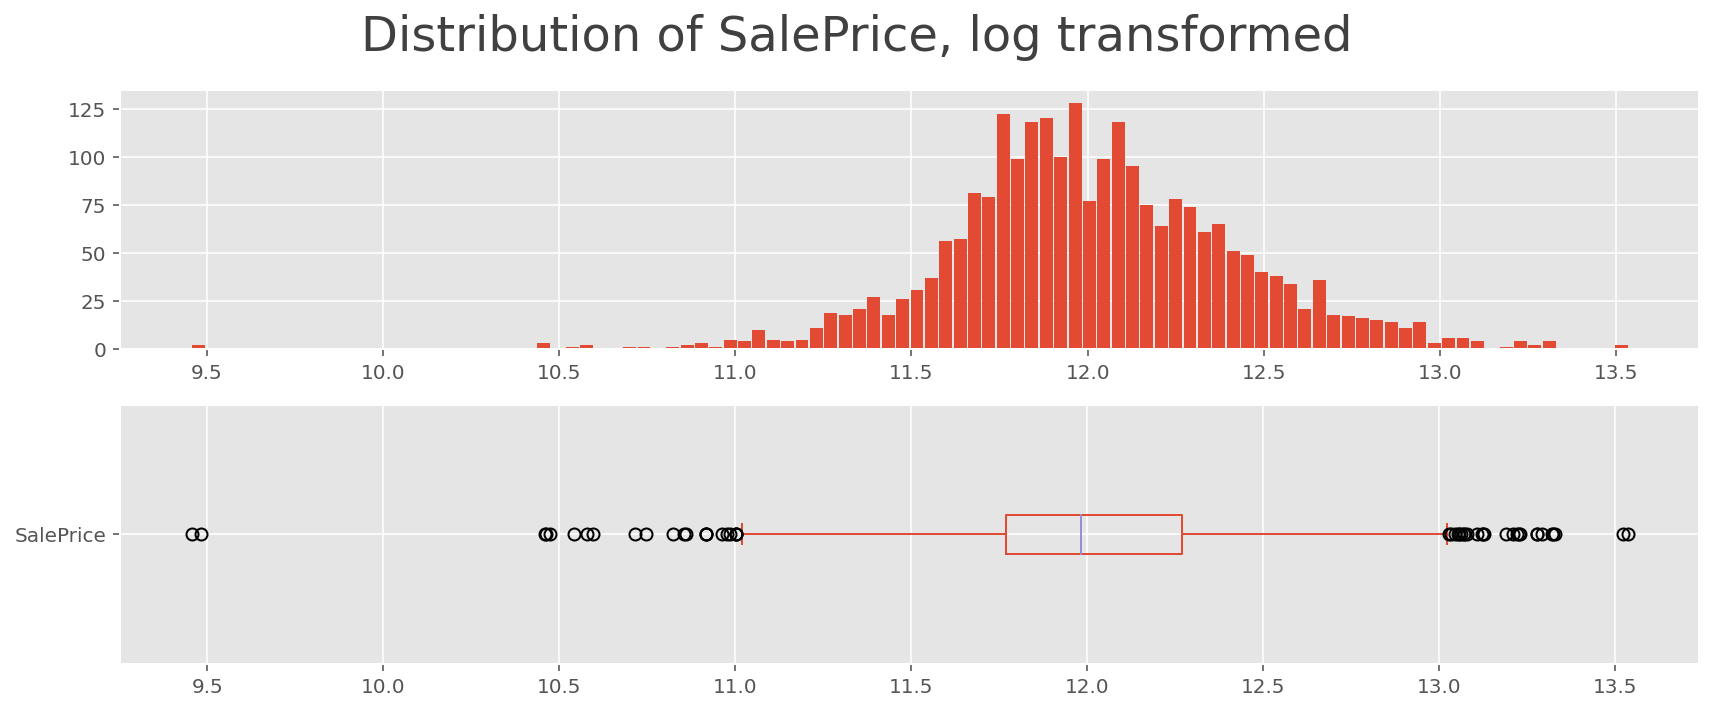

In [17]:
plt.suptitle("Distribution of SalePrice", size=24)
plt.subplot(2,1,1)
df.SalePrice.plot(kind="hist", bins=100, rwidth=.9, figsize=(12,5))
plt.ylabel("")
plt.subplot(2,1,2)
df.SalePrice.plot(kind="box", vert=False)
plt.tight_layout()
plt.show()

plt.suptitle("Distribution of SalePrice, log transformed", size=24)
plt.subplot(2,1,1)
np.log(df.SalePrice).plot(kind="hist", bins=100, rwidth=.9, figsize=(12,5))
plt.ylabel("")
plt.subplot(2,1,2)
np.log(df.SalePrice).plot(kind="box", vert=False)
plt.tight_layout()
plt.show()

Let's **visualize the target together with highly correlated features**.

A scatter plot with sale prices and building year indicates that **houses built more recently seem to yield higher prices**. 

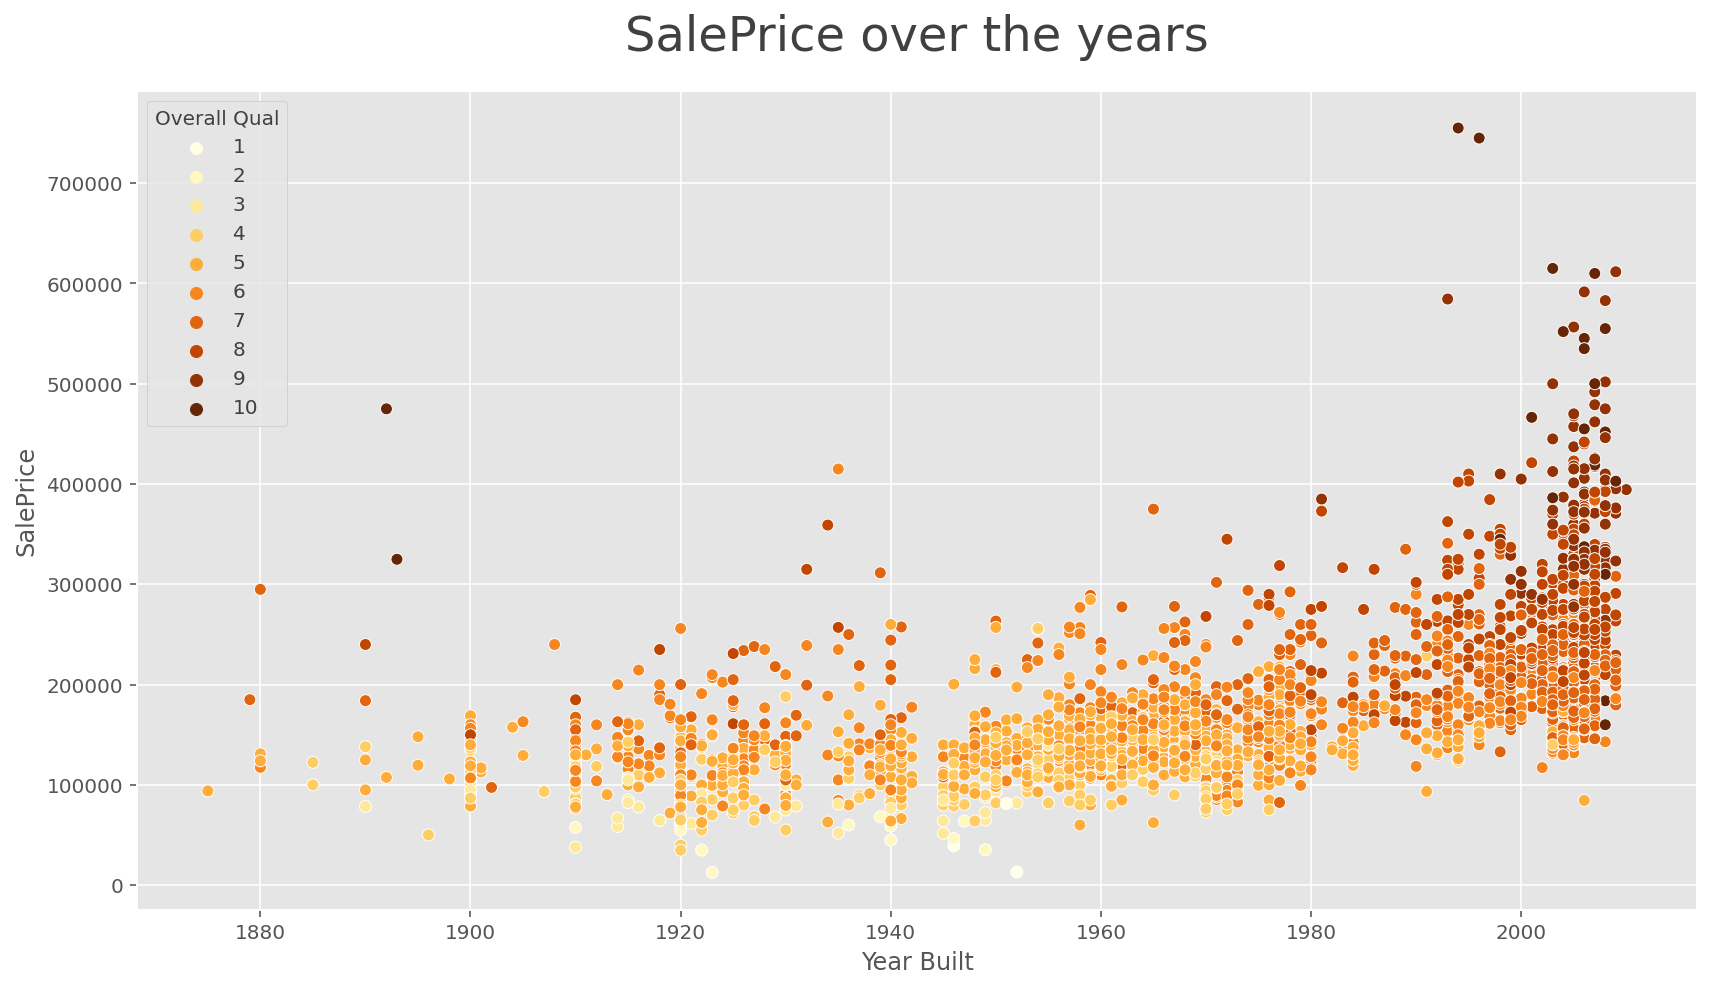

In [18]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x="Year Built", y="SalePrice", hue="Overall Qual", palette="YlOrBr", legend="full")
plt.title("SalePrice over the years", size=24, pad=20)
plt.tight_layout()
plt.show()

The plot is quite cluttered. Therefore let's bin the years to decades.

- We see **a first substantial uptick in sale prices in the 1950's**. Assumption: Building quality increased with economic boom after WWII.
- **From the 70's on there is an almost linear increase** noticable until the latest data from 2010.

In [19]:
bins = np.linspace(1870, 2010, 15)
labels = [str(int(x))+"s" for x in bins]
df["Year_Built_Decades"] = pd.cut(df["Year Built"], bins=bins, labels=bins[:-1]).astype(int)

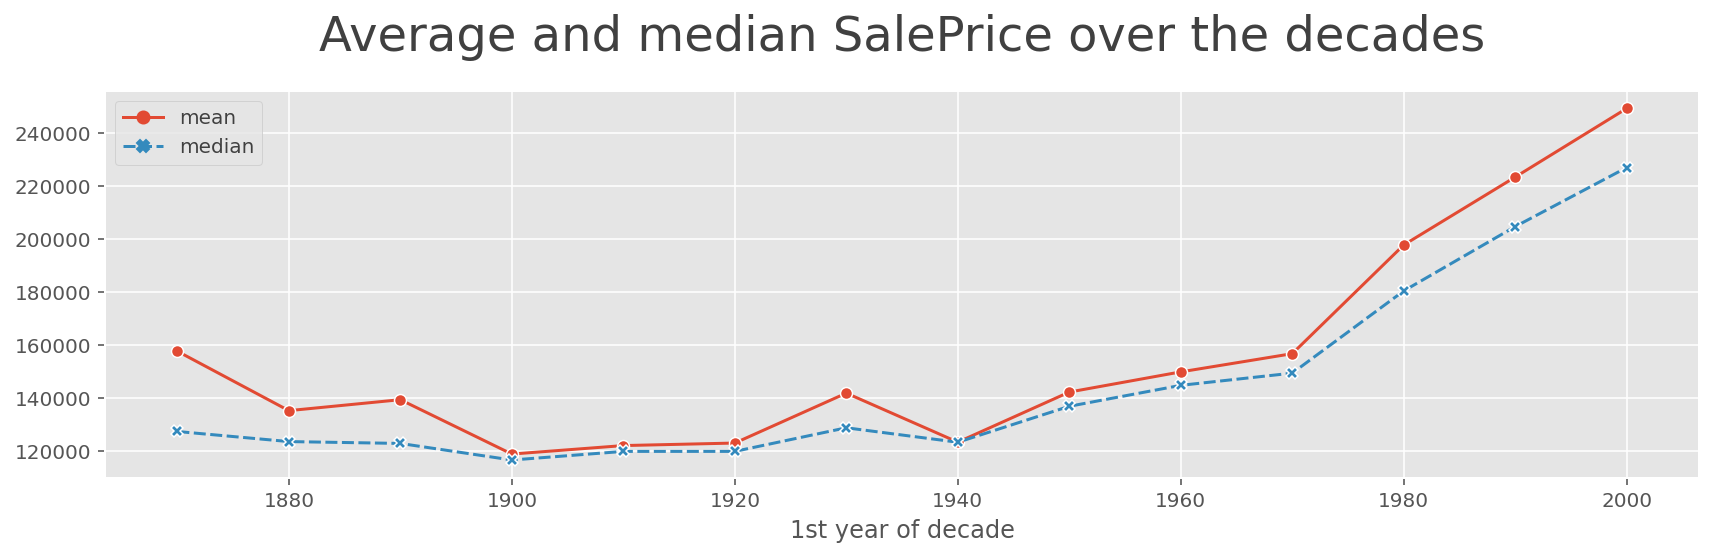

In [20]:
plt.figure(figsize=(12,4))

# Calculate and plot median as well because it is robust towards outliers
tmp = df.groupby("Year_Built_Decades").SalePrice.agg(["mean", "median"])
sns.lineplot(data=tmp, markers=True)
plt.title("Average and median SalePrice over the decades", size=24, pad=20)
plt.xlabel("1st year of decade")
plt.tight_layout()
plt.show()

- With two exceptions from the 1890's **most houses with very high quality material and finish were built between the 80's and 2000's**.

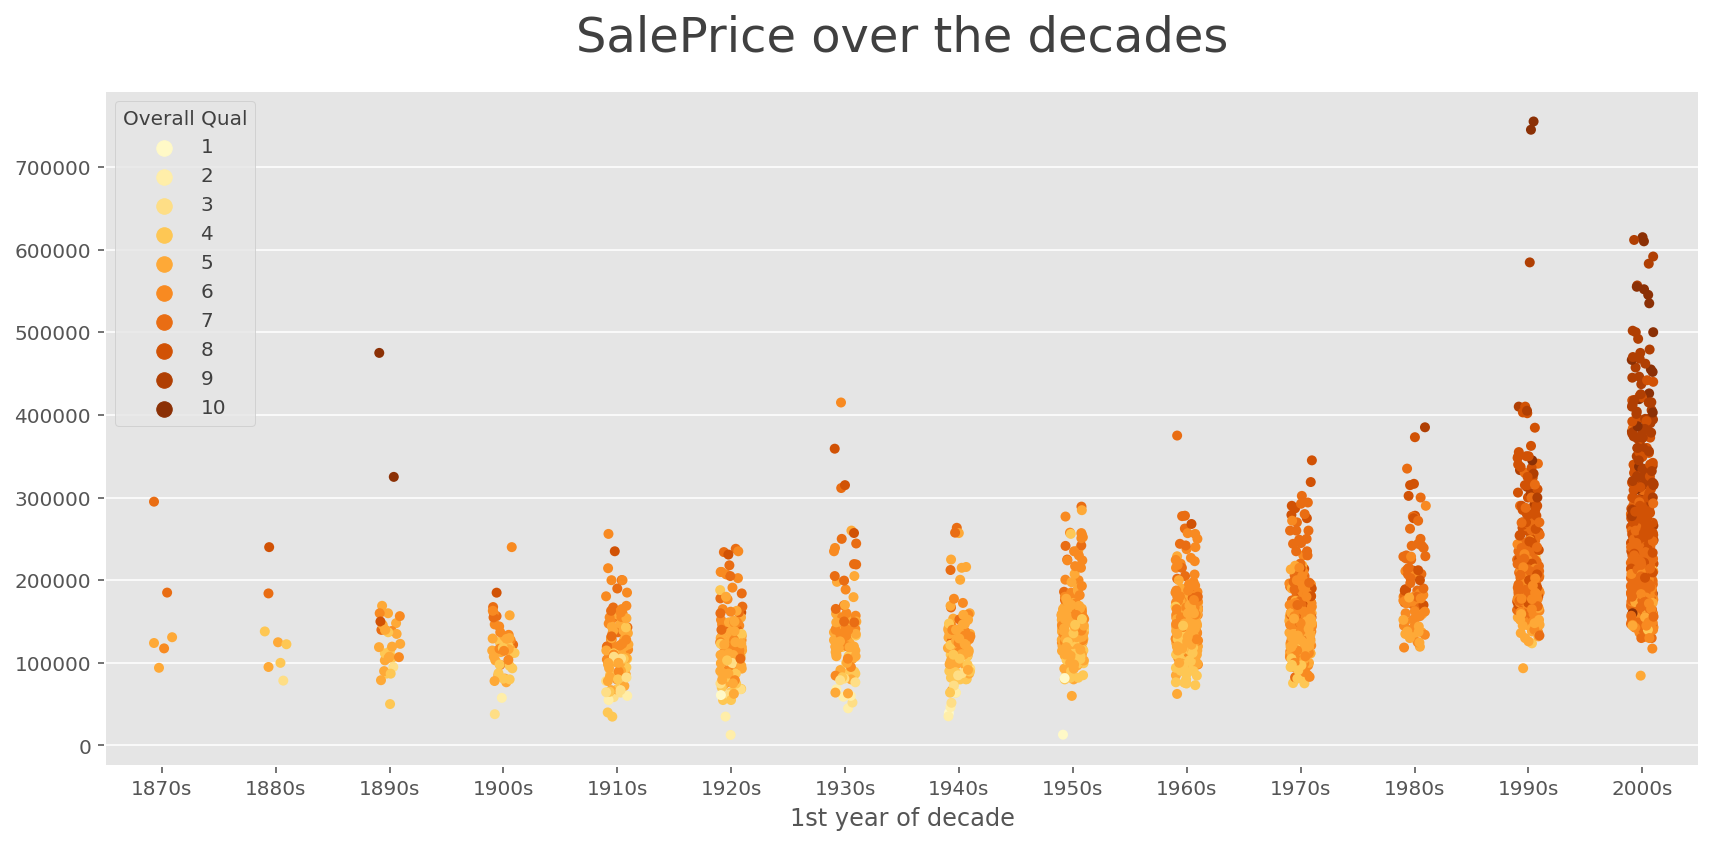

In [21]:
plt.figure(figsize=(12,6))
ax = sns.stripplot(data=df, x="Year_Built_Decades", y="SalePrice", hue="Overall Qual", palette="YlOrBr")
plt.title("SalePrice over the decades", size=24, pad=20)
plt.xlabel("1st year of decade")
plt.xticks(ticks=ax.get_xticks(), labels=labels[:-1])
plt.ylabel("")
plt.tight_layout()
plt.show()

There is **a clear seasonality for the house sales**. Most of the house were sold during summer. We could create a feature «season» to perhaps improve predictions.

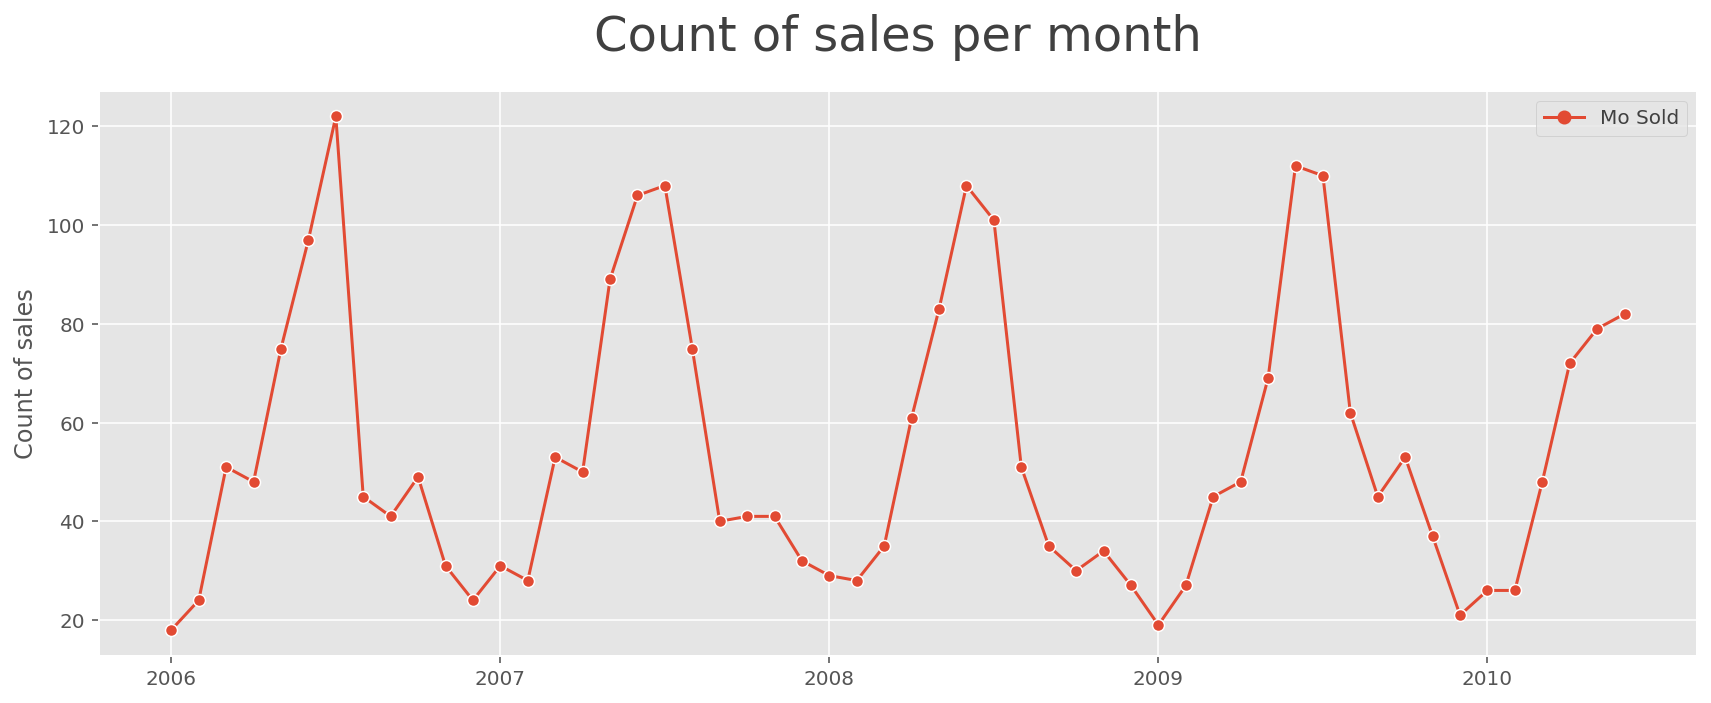

In [22]:
tmp = df.groupby("Yr Sold")["Mo Sold"].value_counts().sort_index()
tmp = pd.DataFrame(tmp)

# Remove values for last incomplete month
tmp = tmp.iloc[:-1]
tmp.index = [f"{str(x[0])[2:]}-{x[1]:02.0f}" for x in tmp.index]

plt.figure(figsize=(12,5))
sns.lineplot(data=tmp, markers=True)
plt.xticks(ticks=tmp.index[::12], labels=list(range(2006, 2011)))

plt.title("Count of sales per month", size=24, pad=20)
plt.ylabel("Count of sales")
plt.tight_layout()
plt.show()

An interesting facet of the time range of the data that likely affects the sales: **[The subprime mortgage crisis in the USA took place between 2007 and 2010!](https://en.wikipedia.org/wiki/Subprime_mortgage_crisis)** In **September 2008 several financial institutions collapsed**, **home prices in the USA declined steeply after peaking in mid-2006.** This might explain the lower prices that we see for 2008 – 2010 in the graph. The effect of the crisis doesn't seem very pronounced though.

Apart from that, I **do not see any clear seasonal pattern in sales prices**. 

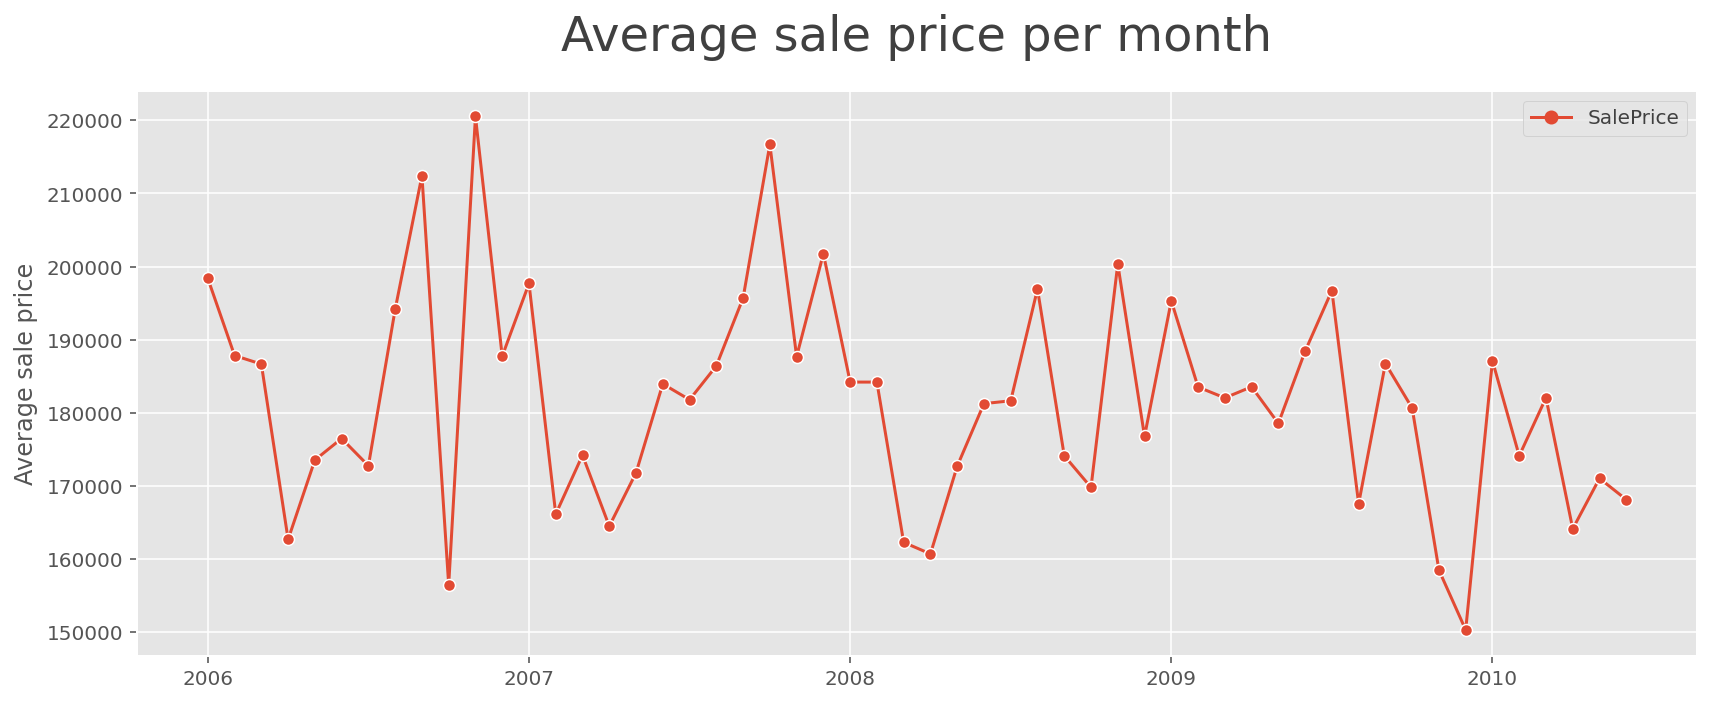

In [23]:
tmp = df.groupby(["Yr Sold", "Mo Sold"]).SalePrice.mean().sort_index()
tmp = pd.DataFrame(tmp)

# Remove values for last incomplete month
tmp = tmp.iloc[:-1]
tmp.index = [f"{str(x[0])[2:]}-{x[1]:02.0f}" for x in tmp.index]

plt.figure(figsize=(12,5))
sns.lineplot(data=tmp, markers=True)
plt.xticks(ticks=tmp.index[::12], labels=list(range(2006, 2011)))

plt.title("Average sale price per month", size=24, pad=20)
plt.ylabel("Average sale price")
plt.tight_layout()
plt.show()

Looking at the sales per month we notice nonetheless that **April has been the worst month to sell a house** or it was on an average the month when less expensive houses got sold more often. **More expensive sales were made in September and November.**

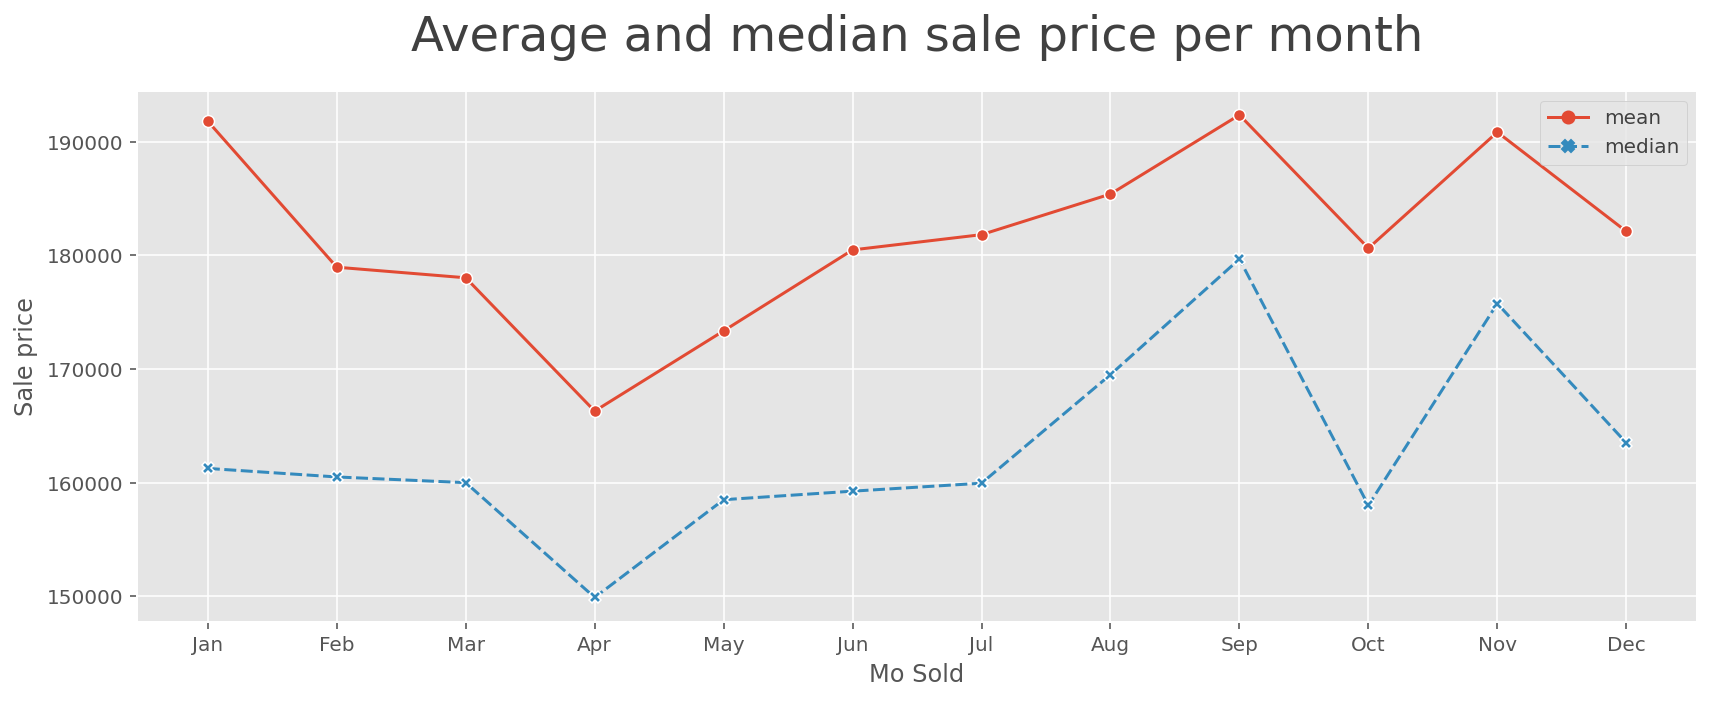

In [24]:
tmp = df.groupby("Mo Sold").SalePrice.agg(["mean", "median"]).sort_index()
tmp = pd.DataFrame(tmp)

plt.figure(figsize=(12,5))
sns.lineplot(data=tmp, markers=True)
plt.xticks(ticks=tmp.index, labels=MONTH_NAMES)

plt.title("Average and median sale price per month", size=24, pad=20)
plt.ylabel("Sale price")
plt.tight_layout()
plt.show()

A stripplot of the sale prices binned by the **overall quality** ranking shows:
- a **quality of 3 to 9 increasingly makes a substantial difference in sale price**
- there is **almost no difference in the price range for ranking 9 and 10**, apart from 2 outliers beyond 700k
- we do only have **very few samples at the low end of quality**

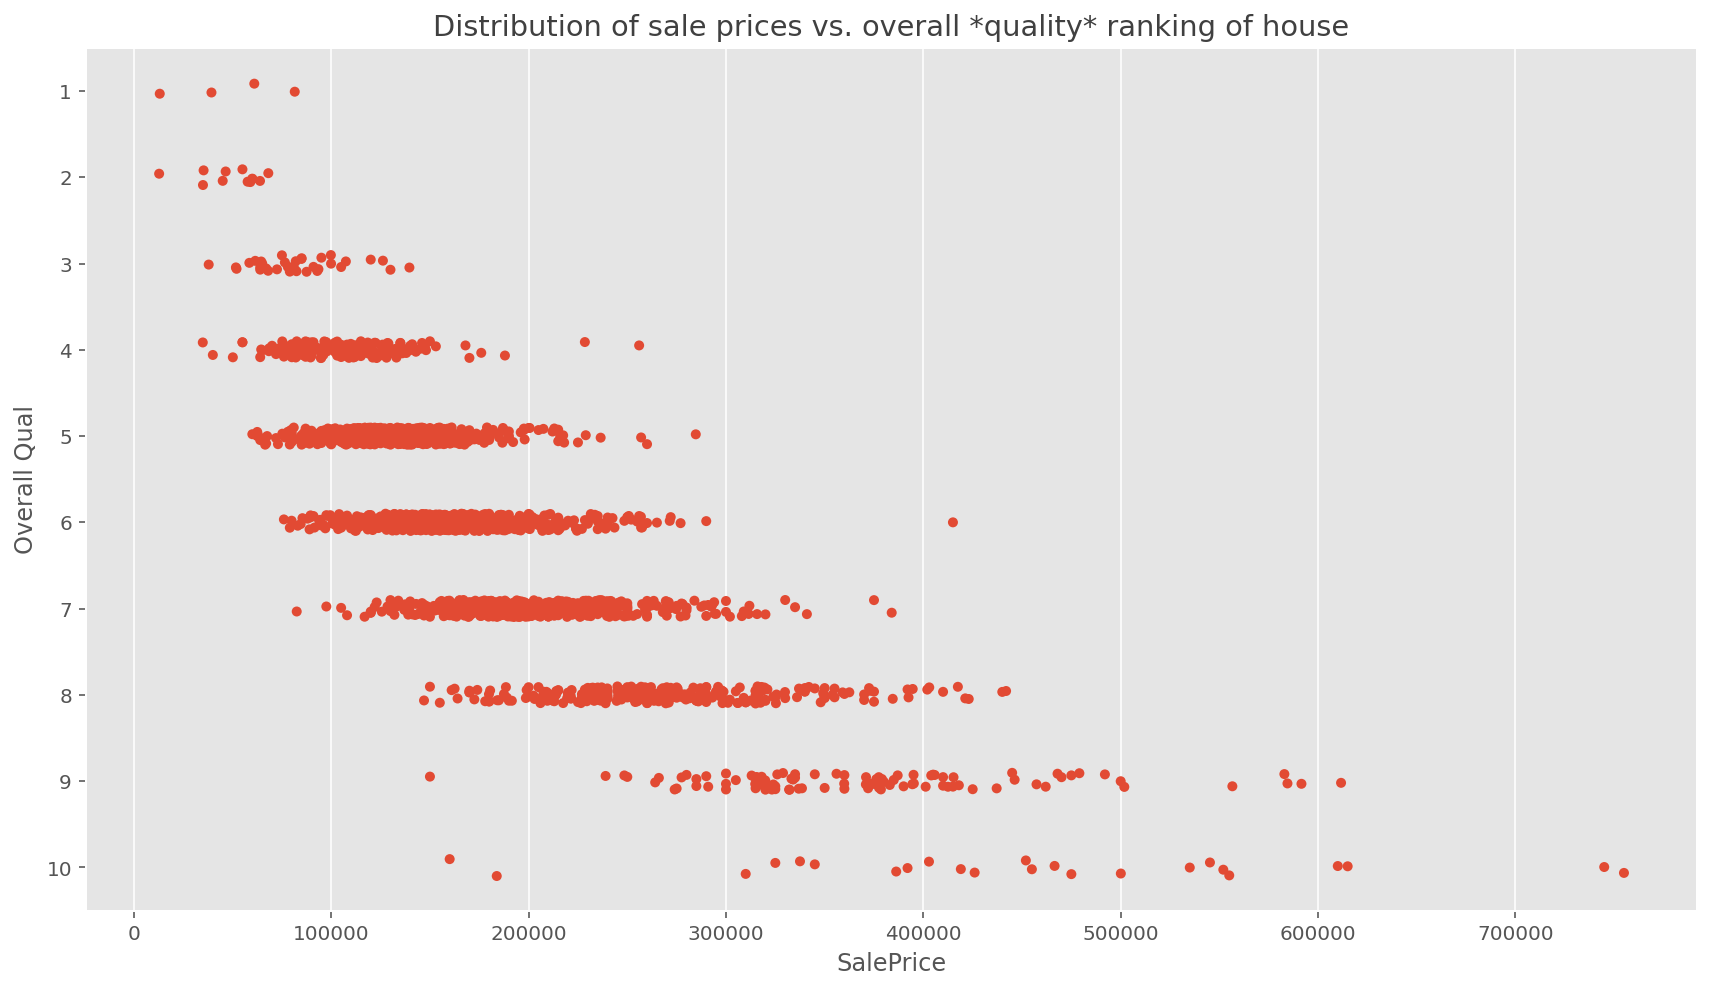

In [25]:
plt.figure(figsize=(12,7))
sns.stripplot(data=df, x="SalePrice", y="Overall Qual", orient="h", color="#E24A33")
plt.title("Distribution of sale prices vs. overall *quality* ranking of house")
plt.tight_layout()
plt.show()

The same stripplot but regarding the **overall condition** shows:
- the **mayority of samples has a condition of 5**
- the **increase of price seems much subtler** between the different condition values
- the **two outliers beyond 700k rank 5 and 6**, so these seem to be houses in average condition but with superior material and finish

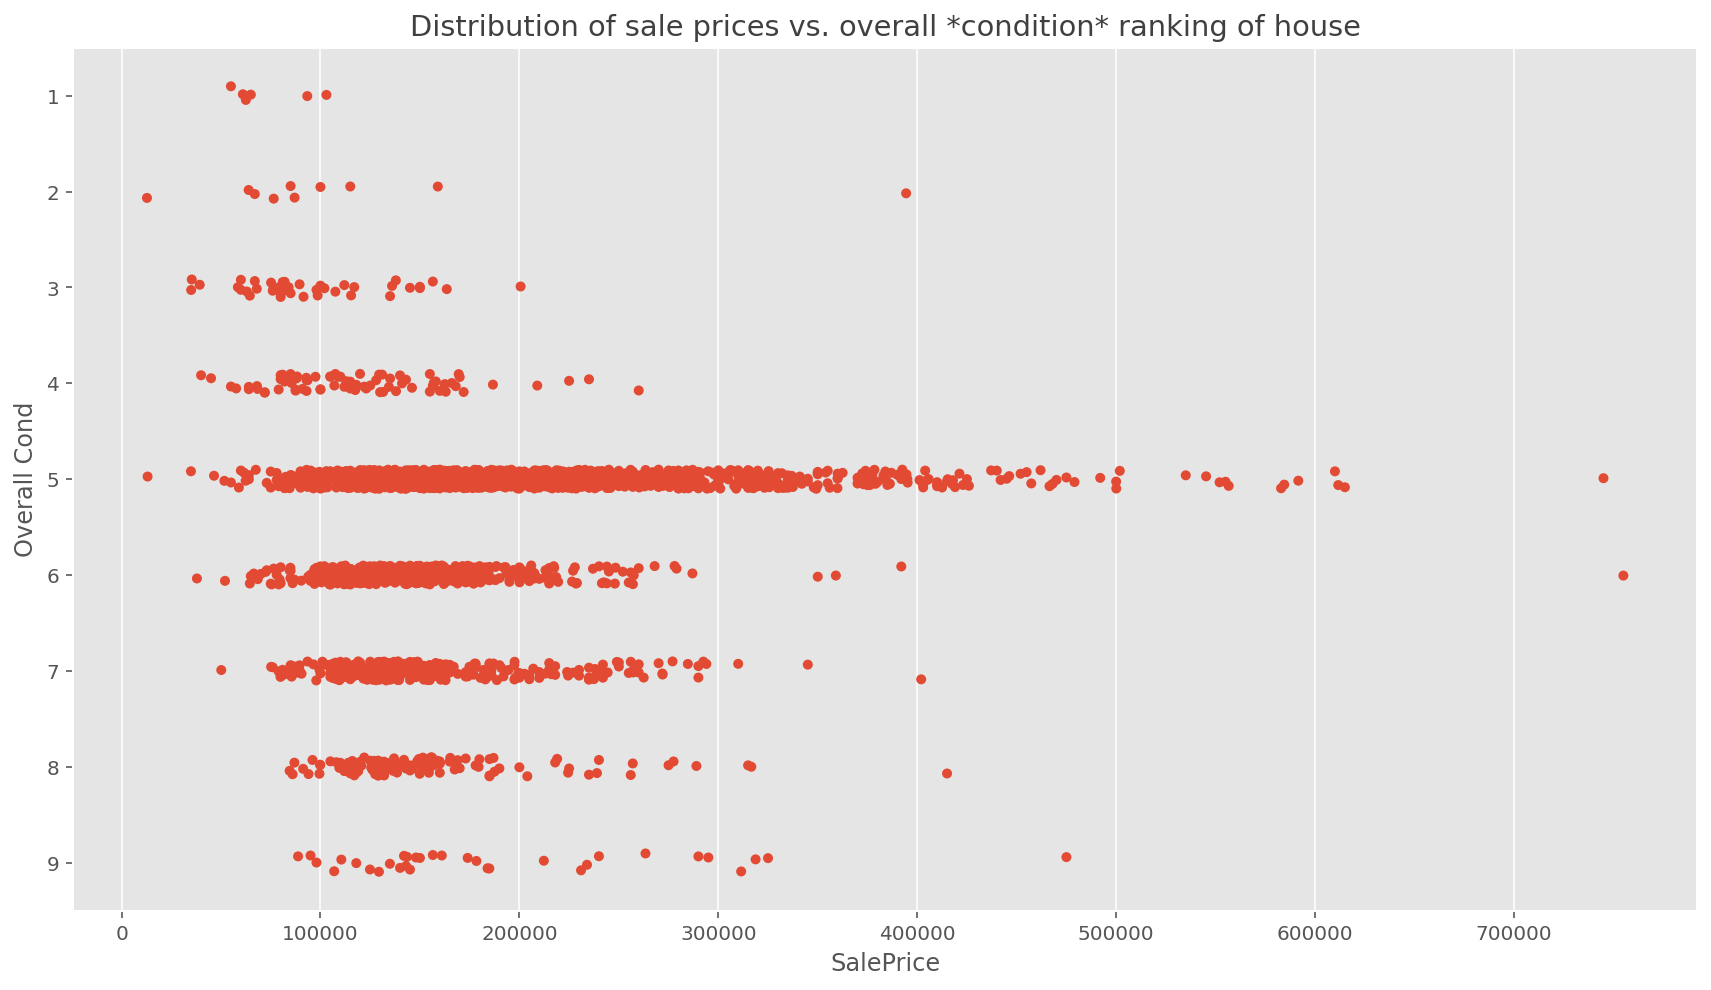

In [26]:
plt.figure(figsize=(12,7));
sns.stripplot(data=df, x="SalePrice", y="Overall Cond", orient="h", color="#E24A33")
plt.title("Distribution of sale prices vs. overall *condition* ranking of house")
plt.tight_layout()
plt.show()

# Data cleaning
---

**Reload data**

In [27]:
# Starting fresh with a reload of the data.
df = pd.read_csv("_data/house-prices.csv")
df_test = pd.read_csv("_data/house-prices-test.csv")

# Since I need to clean the data in both data sets, I concatenate the two dataframes.
df = pd.concat([df, df_test])
df.reset_index(drop=True, inplace=True)
df["testset"] = np.where(df.SalePrice.isna(), True, False)

# Clean columns names for easier handling.
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(r"\W", "_", regex=True)

**Fix missing values one by one**

In [28]:
cols_nans = df.columns[df.isna().any()].to_list()
cols_nans.remove("saleprice")
print("Feature columns to fix:")
print(cols_nans)

Feature columns to fix:
['lot_frontage', 'alley', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'electrical', 'bsmt_full_bath', 'bsmt_half_bath', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature']


In [29]:
# Missing values likely mean no street connected to property, Set dtype to integer
df.lot_frontage = df.lot_frontage.fillna(0).astype(int)

# NA means no alley acces therefore we fill with string «NA» which is a given label
df.alley = df.alley.fillna("NA")

# Fill NaNs with None which already is a given label
df.mas_vnr_type = df.mas_vnr_type.fillna("None")

# Fill NaNs with 0 to indicate no veneer area and set to integer
df.mas_vnr_area = df.mas_vnr_area.fillna(0).astype(int)

# Fill NaNs with NA which already is a given label for all categorical basement features
bsmt_cols = ['bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2']
for col in bsmt_cols:
    df[col] = df[col].fillna("NA")
    
# NaNs likely mean 0 == no basement, setting to integer too
for col in ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath']:
    df[col] = df[col].fillna(0).astype(int)
    
# NaNs likely means unknown, filling with most frequent value which is SBrkr
df.electrical = df.electrical.fillna("SBrkr")

# NANs likely mean no fireplace, filling with «None»
df.fireplace_qu = df.fireplace_qu.fillna("NA")

# NANs likely mean no fence, filling with «None»
df.fence = df.fence.fillna("NA")

# NANs for garage features likely mean no garage, filling with "None"
grg_cols = ['garage_type', 'garage_finish', 'garage_qual', 'garage_cond']
for col in grg_cols:
    df[col] = df[col].fillna("NA")

# NaNs likely mean no garage == 0
# Setting built year for no garage to 0 as well
for col in ['garage_yr_blt', 'garage_cars', 'garage_area']:
    df[col] = df[col].fillna(0).astype(int)    
    
# Fix outlier GarageYrBlt == 2207 and fill with mean
to_fix = df[df.garage_yr_blt == 2207].index
# Careful here to not leak data from test set
df.loc[to_fix, "garage_yr_blt"] = int(df[df.testset.notnull()].garage_yr_blt.mean())

# NaNs likely mean no feature, filling with NA which is a given label
df.misc_feature = df.misc_feature.fillna("NA")

# NaNs likely mean no pool, filling with None
df.pool_qc = df.pool_qc.fillna("NA")

**Sanity check**

In [30]:
null_values = df.drop("saleprice", axis=1).columns[df.drop("saleprice", axis=1).isna().any()].shape[0]
assert null_values == 0
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order            2930 non-null   int64  
 1   pid              2930 non-null   int64  
 2   ms_subclass      2930 non-null   int64  
 3   ms_zoning        2930 non-null   object 
 4   lot_frontage     2930 non-null   int64  
 5   lot_area         2930 non-null   int64  
 6   street           2930 non-null   object 
 7   alley            2930 non-null   object 
 8   lot_shape        2930 non-null   object 
 9   land_contour     2930 non-null   object 
 10  utilities        2930 non-null   object 
 11  lot_config       2930 non-null   object 
 12  land_slope       2930 non-null   object 
 13  neighborhood     2930 non-null   object 
 14  condition_1      2930 non-null   object 
 15  condition_2      2930 non-null   object 
 16  bldg_type        2930 non-null   object 
 17  house_style   

None

**Validation of year built vs year sold**

We have one sample where the `year_built` is the year after the year of sales. Fixing this to same year.

In [31]:
display((df.yr_sold - df.year_built).sort_values().head(5))
print()
display(df.loc[71][["yr_sold","year_built" ]])
df.loc[71, "year_built"] = 2007
display(df.loc[71][["yr_sold", "year_built"]])

71     -1
2076    0
2604    0
130     0
1788    0
dtype: int64

yr_sold       2007
year_built    2008
Name: 71, dtype: object

yr_sold       2007
year_built    2007
Name: 71, dtype: object

**Handle outliers**

Remove houses with more than 4'000 square feet according Dean De Cocks recommendation.

In [32]:
# Need to make sure not to drop samples from the test set
to_drop = df[(df.testset==0) & (df.gr_liv_area > 4000)].index
df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)

Most outliers are on the right/higher end of the value spectrum. I remove extreme outliers beyond 3 * IQR.

In [33]:
outlier_count = 0
for col in df.select_dtypes("number").columns:
    q25 = percentile(df[col], 25)
    q75 = percentile(df[col], 75)
    iqr = q75 - q25
    upper = q75 + iqr * 3
    # Again make sure we do not drop data from the test set
    to_drop = df[(df.testset==0) & (df[col] > upper)].index
    outlier_count += len(to_drop)
    df.drop(to_drop, inplace=True)
    
df.reset_index(drop=True, inplace=True)
print(f"{outlier_count} outliers removed")

1069 outliers removed


# Feature encoding
---

**Properly encoding categorical features**

In [34]:
# Features are encoded numerical but actually categorical
df.ms_subclass = df.ms_subclass.astype(str)
df.mo_sold = df.mo_sold.astype(str)
# Encode binary categorical to numeric
df.central_air = np.where(df.central_air=="Y", 1,0)

# Encode all ordinal features according to data description from Dean De Cock
mapping = {"NA" : 0, "IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4}
df.lot_shape = df.lot_shape.map(mapping)

mapping = {"NA" : 0, "ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
df.utilities = df.utilities.map(mapping)

mapping = {"NA" : 0, "Sev" : 1, "Mod" : 2, "Gtl" : 3}
df.land_slope = df.land_slope.map(mapping)

mapping = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}
df.exter_qual = df.exter_qual.map(mapping)
df.exter_cond = df.exter_cond.map(mapping)
df.bsmt_qual = df.bsmt_qual.map(mapping)
df.bsmt_cond = df.bsmt_cond.map(mapping)
df.heating_qc = df.heating_qc.map(mapping)
df.kitchen_qual = df.kitchen_qual.map(mapping)
df.fireplace_qu = df.fireplace_qu.map(mapping)
df.garage_qual = df.garage_qual.map(mapping)
df.garage_cond = df.garage_cond.map(mapping)
df.pool_qc = df.pool_qc.map(mapping)

mapping = {"NA" : 0, "No" : 2, "Mn" : 2, "Av": 3, "Gd" : 4}
df.bsmt_exposure = df.bsmt_exposure.map(mapping)

mapping = {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
df.bsmtfin_type_1 = df.bsmtfin_type_1.map(mapping)
df.bsmtfin_type_2 = df.bsmtfin_type_2.map(mapping)

mapping = {"NA" : 0, "Mix" : 1, "LwQ": 2, "FuseP" : 3, "FuseF" : 4, "FuseA" : 5, "SBrkr" : 6}
df.electrical = df.electrical.map(mapping)

mapping = {"NA" : 0, "Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8}
df.functional = df.functional.map(mapping)

mapping = {"NA" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3}
df.garage_finish = df.garage_finish.map(mapping)

mapping = {"NA" : 0, "MnWw" : 1, "GdWo" : 2, "MnPrv": 3, "GdPrv" : 4}
df.fence = df.fence.map(mapping)

mapping = {"NA" : 0, "N" : 0, "P" : 1, "Y" : 2}
df.paved_drive = df.paved_drive.map(mapping)

# Feature engineering
---

I create new features by:

- mapping sales months to «seasons»
- calculating the actual age at the moment of sale
- calculating synthetic quality scores by multiplying features of condition, quality and area
- adding polynomials

I tried other combinations as well but removed these because they did not seem to improve the models.

In [35]:
## ------------- engineered features that didn´t improve scoring ------------- ##

# for feature in ["pool_area", "2nd_flr_sf", "garage_area", "total_bsmt_sf", "fireplaces"]:
#     df[f"has_{feature}"] = np.where(df[feature]>0, 1, 0)

# df["overall_score"] = df.overall_qual * df.overall_cond * df.gr_liv_area
# df["lot_score"] = df.lot_area * df.lot_frontage
# df["garage_score"] = df.garage_qual * df.garage_cond * df.garage_area * df.garage_cars
# df["kitchen_score"] = df.kitchen_abvgr * df.kitchen_qual
# df["fireplace_score"] = df.fireplaces * df.fireplace_qu
# df["pool_score"] = df.pool_area * df.pool_qc

# # trying to create «pseudo ordinals» by binning several numerical features
# bin_cols = ["lot_frontage", "lot_area", "year_built", "year_remod_add", "mas_vnr_area", 
#             'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', 
#             '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', "garage_yr_blt", 'garage_area', 
#             'wood_deck_sf', 'open_porch_sf']

# frames = []
# for bin_col in bin_cols:
#     tmp = pd.DataFrame(pd.cut(df[bin_col], bins=10, labels=np.arange(0,10)))
#     tmp.columns = [bin_col + "_binned"]
#     frames.append(tmp)
    
# df_bin = pd.concat(frames, axis=1).astype(int)
# df = pd.concat([df, df_bin], axis=1).copy()

In [36]:
## -------------- engineered features that do improve scoring -------------- ##

# Convert months to seasons
seasons = {"1" : 0, "2" : 0, "3" : 0, "4" : 1, 
           "5" : 1, "6" : 1, "7" : 2, "8" : 2, 
           "9" : 2, "10" : 3, "11" : 3, "12" : 3
          }
df["season_sold"] = df["mo_sold"].map(seasons).astype(str)

# Create feature with actual time difference in year of sale
df["yr_actual_age"] = df.yr_sold - df.year_built
df["yr_actual_remod"] = df.yr_sold - df.year_remod_add

# Create polynomials for top correlated feature
poly = PolynomialFeatures(degree=2, include_bias=False)
top_correlated = ["gr_liv_area"]
df_poly = pd.DataFrame(poly.fit_transform(df[top_correlated].values))
df_poly.columns = ["poly" + str(x) for x in range(len(df_poly.columns))]
df = pd.concat([df, df_poly], axis=1)

# Final one hot encoding and scaling of features
---

In [37]:
df_num = df.select_dtypes("number").drop(["order", "pid", "saleprice"], axis=1).copy()
df_obj = df.drop(df_num.columns, axis=1).drop(["order", "pid", "saleprice"], axis=1).copy()

sc = StandardScaler()
# Fit scaler only on training data
sc.fit(df_num[df_obj.testset==0])
df_scaled = sc.transform(df_num)
df_scaled = pd.DataFrame(df_scaled, columns=df_num.columns)

df_ohe = pd.get_dummies(df_obj, drop_first=True)
df = pd.concat([df[["order", "pid", "saleprice"]], df_scaled, df_ohe], axis=1).copy()

# Model fitting
---

First we need to separate the training data again from test data.

In [38]:
df_train = df[df.testset==0].copy()
df_test  = df[df.testset==1].copy().reset_index(drop=True)

X = df_train.drop(["saleprice", "order", "pid", "testset"], axis=1).copy()
X_test = df_test.drop(["saleprice", "order", "pid", "testset"], axis=1).copy()
y = df_train.saleprice.copy()

## **(0.) 1st baseline with DummyRegressor**
As expected we get an R2 score very close to 0. The mean absolute error is 55'428 USD.

In [39]:
X_ = X.select_dtypes("number")
clf_dummy = DummyRegressor()
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=0)
clf_dummy.fit(X_train, y_train)
y_pred = clf_dummy.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print(f"R2: {clf_dummy.score(X_test, y_test):.4f} | MAE: {MAE:.0f}")

R2: -0.0001 | MAE: 55133


## **(0.) 2nd baseline with LinearRegression and just one numerical feature**
I choose the most correlated «true» continuous feature for the second baseline. This already yields a not so bad R2 score of 0.55 and a better MAE too.

In [40]:
X_ = X.select_dtypes("number")["gr_liv_area"].values
X_ = X_[:, np.newaxis]
clf_lin = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=0)
clf_lin.fit(X_train, y_train)
y_pred = clf_lin.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print(f"R2: {clf_lin.score(X_test, y_test):.2f} | MAE: {MAE:.0f}")

R2: 0.55 | MAE: 36316


I validate more thoroughly by applying cross validation and taking the average of the validation scores. We get a more robust measure.

In [41]:
cv = 10
r2_avg = np.mean(cross_val_score(clf_lin, X_, y, cv=cv))
print(f"Average R2: {r2_avg:.2f} of {cv} cross validations")

Average R2: 0.57 of 10 cross validations


## **(0.) Make the workflow more flexible** 
- Use a pipeline
- Use the `cross_validate` function that allows to retrieve more than one scoring metric
- Queue several regressors in a loop
- Encapsulate everything in reusable functions

In [42]:
# log() and log1p() yield almost identical scoring results as a transformation for the target variable
def func(x):
    return np.log1p(x)
def inverse_func(x):
    return np.expm1(x)


def get_correlations(data):
    corrs = data.select_dtypes("number").corr()["saleprice"]
    # Consider absolute correlation for top list of features
    corrs = np.abs(corrs).sort_values(ascending=False).drop("saleprice")
    return corrs


def get_scores(sc):
    sc = {k.replace("test_", ""):v for (k, v) in sc.items() if "test" in k}
    sc = {k:np.mean(v) for (k,v) in sc.items()}
    sc = list(sc.values())
    return sorted(sc)

   
MAX_ITER = 100_000  

def do_regression(X, y, cv=5, transform_target=False,
                  huber_only=False, huber_epsilon=1.35, huber_alpha=0.0001, 
                  ):
    
    clf_names = ["dummy", "linreg", "huber", "ridge", "lasso"]
    clfs = [DummyRegressor(), 
            LinearRegression(), 
            HuberRegressor(max_iter=MAX_ITER, epsilon=huber_epsilon, alpha=huber_alpha), 
            Ridge(), 
            Lasso(max_iter=MAX_ITER)
           ]
    
    if huber_only==True:
        clf_names = ["huber"]
        clfs = [HuberRegressor(max_iter=MAX_ITER, epsilon=huber_epsilon, alpha=huber_alpha)]
        
    clfs_pipeline = [(name, clf) for name, clf in zip(clf_names, clfs)]
    
    if transform_target==True:
        clfs_pipeline = []
        for name, clf in zip(clf_names, clfs):
            clf_ = TransformedTargetRegressor(regressor=clf, 
                                              func=func,
                                              inverse_func=inverse_func,
                                              check_inverse=False
                                             )
            clfs_pipeline.append((name, clf_))
    
    # The MAE here has to be «neg» (aka negative) because 
    # by convention errors in scikit have to be higher to be «better».
    scoring = ["neg_mean_absolute_error", 'r2']
    scoring_names = ["MAE", 'R2']
    
    results = []
    for named_clf in clfs_pipeline:
        pipe = Pipeline([named_clf])
        scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring)
        scores = get_scores(scores)
        results.append(scores)
    tmp = pd.DataFrame(results, columns=scoring_names, index=clf_names).sort_values(by="R2", ascending=False)
    # Negate value of «neg_mean_absolute_error» to get properly signed values
    tmp.MAE = -tmp.MAE.astype(int)
    return tmp


def get_huber_pipeline(huber_epsilon=1.35, huber_alpha=0.0001):
    clf = HuberRegressor(max_iter=MAX_ITER, epsilon=huber_epsilon, alpha=huber_alpha)
    clf_ = TransformedTargetRegressor(regressor=clf, 
                                      func=func,
                                      inverse_func=inverse_func,
                                      check_inverse=False,
                                      )
    pipe = Pipeline([("huber", clf_)])
    return pipe

In [43]:
X_ = X.select_dtypes("number")["gr_liv_area"].values
X_ = X_[:, np.newaxis]

results = do_regression(X_, y)
display(results.style
        .highlight_max(subset=["R2"], color='lightgreen')
        .highlight_min(subset=["MAE"], color='lightgreen')
       )

,MAE,R2
ridge,35521,0.572179
lasso,35525,0.572166
linreg,35525,0.572166
huber,35020,0.567464
dummy,56785,-0.004326


With just one single numerical feature the Ridge and Huber regressors perform best.

How can I interpret the **better R2 score for Ridge vs. the lower MAE for Huber**? 
- I assume from the EDA that we still have outliers in our predicting features (despite removing the extreme ones).
- The R2 is sensitive to outliers whereas the MAE is more robust. 
- The MAE is easily interpretable in this case – the Huber model's predictions on average deviate by 35k USD from the true values. 

In this case I assume that **the Huber model performs slightly better than ridge/lasso/linear regression despite its slightly worse R2.**

---
## **(1.) Simple model with two variables**
- For the simplest model I choose **the two highest correlated numerical variables to the target**.
- The **results already are much better. Both R2 and MAE have improved substantially.**

In [44]:
corr = get_correlations(df)
top_n = 2
print(f"Selected features: {list(corr[:top_n].index)}")
X_ = X[corr[:top_n].index]

results_simple = do_regression(X_, y)
display(results_simple.style
        .highlight_max(subset=["R2"], color='lightgreen')
        .highlight_min(subset=["MAE"], color='lightgreen')
       )

Selected features: ['overall_qual', 'gr_liv_area']


,MAE,R2
ridge,26046,0.774104
lasso,26050,0.774097
linreg,26050,0.774097
huber,25642,0.769595
dummy,56785,-0.004326


#### ⚠️ <span style="color:darkred">Result: The simple model (Huber) has an MAE of 25'642 USD and an R2 score of 0.77.</span>

Make predictions with simple model.

In [45]:
clf_simple = get_huber_pipeline()
clf_simple.fit(X_, y)

# Prepare test data the same way as the training data
X_test = df_test.drop("saleprice", axis=1).copy()
X_test_simple = X_test[corr[:top_n].index]

y_pred = clf_simple.predict(X_test_simple)

df_predictions = df_test.pid.to_frame().copy()
df_predictions.columns = ["PID"]
df_predictions["SalePrice"] = y_pred
df_predictions.reset_index(drop=True, inplace=True)
df_predictions.to_csv("predictions-simple-model.csv", index=False)
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PID        500 non-null    int64  
 1   SalePrice  500 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.9 KB


---
## **(2.) Intermediate model with 10-20 variables**
For selecting the 10-20 variables I use scikit's `SelectKBest` function and focus on Huber as the most promising regressor from the previous experiments. To get an overview I try out increasing values for the total of selected features up to the full feature set.

Findings:
- **More features generally improve the score substantially.** The optimum number of selected features seems to be around 110 features. Beyond that the scores deterioate.
- **Transforming the target to a more normal distribution very much improves the results** (using the `TransformedTargetRegressor`).
- To norm the distribution of `SalePrice` a `QuantileTransformer` performs good but `log()` and `log1p()` perform even better.

In [46]:
# Drop features that only have 1 unique value in the training set because KBest can't handle these
tmp = X.nunique().sort_values()
to_drop = tmp[tmp==1].index
X_ = X.drop(to_drop, axis=1).copy()

In [47]:
frames = []

for k in tqdm(range(10, X_.shape[1], 20)):
    sel_kb = SelectKBest(f_regression, k=k)
    sel_kb.fit(X_, y)
    kbest_cols = X_.iloc[:, sel_kb.get_support()].columns
    tmp = do_regression(X_[kbest_cols], y, 
                        huber_only=True,
                        transform_target=True
                       )
    tmp["kbest_k"] = k 
    frames.append(tmp)
    
results_kbest = pd.concat(frames).reset_index(drop=True).sort_values("MAE") 
display(results_kbest.style
            .highlight_max(subset=["R2"], color='lightgreen')
            .highlight_min(subset=["MAE"], color='lightgreen')
            .hide_index()
       )

  0%|          | 0/10 [00:00<?, ?it/s]

MAE,R2,kbest_k
12193,0.939671,110
12219,0.936055,130
12410,0.937564,90
12467,0.931679,150
12965,0.894731,170
13140,0.905248,190
13219,0.928316,70
13724,0.928235,50
14363,0.921364,30
17273,0.892379,10


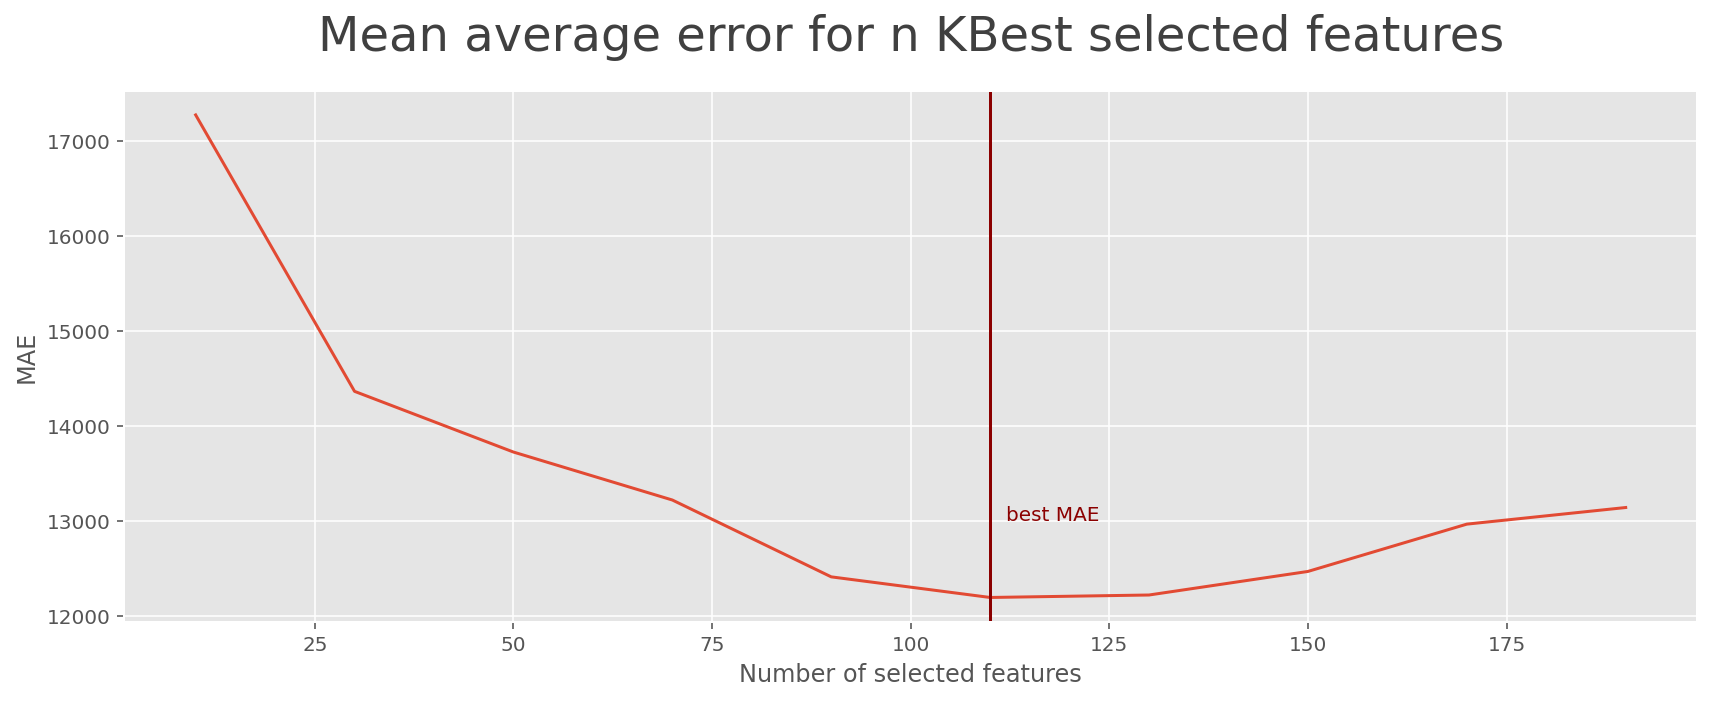

In [48]:
best_mae = results_kbest.loc[results_kbest.MAE.idxmin()].kbest_k

plt.figure(figsize=(12,5))
sns.lineplot(data=results_kbest, x="kbest_k", y="MAE")
plt.title("Mean average error for n KBest selected features", size=24, pad=20)
plt.xlabel("Number of selected features")
plt.axvline(best_mae, color="darkred")
plt.text(best_mae+2, 13_000, 'best MAE', c="darkred")
plt.tight_layout()
plt.show()

#### Gridsearching regularization and epsilon for Huber regressor

In [49]:
def gridsearch_huber(X_, y, alpha_range, eps_range, cv=5):
    parameters = {'huber__regressor__alpha':alpha_range, 'huber__regressor__epsilon':eps_range}
    pipe = get_huber_pipeline()
    grid_cv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=cv)
    grid_cv.fit(X_, y);

    best_alpha = grid_cv.best_params_["huber__regressor__alpha"]
    best_eps = grid_cv.best_params_["huber__regressor__epsilon"]
    print(f"Best alpha: {best_alpha:.6f} | Best epsilon: {best_eps:.2f}")
    
    pd.DataFrame(grid_cv.cv_results_["mean_test_score"]).plot()
    ticks = [f"e:{x['huber__regressor__epsilon']:.0f} a:{x['huber__regressor__alpha']:.4f}" for x in grid_cv.cv_results_["params"]]
    plt.xticks(ticks=range(0, len(ticks),5), labels=ticks[::5], rotation=45, ha="right")
    best_score = np.argmin(grid_cv.cv_results_["rank_test_score"])
    plt.axvline(best_score, c="darkred")
    plt.xlabel("Grid searched parameter combinations (dark red line == best values)")
    plt.ylabel("R2 score")
    plt.legend("")
    plt.tight_layout()
    plt.show()    
    return best_alpha, best_eps, grid_cv.best_estimator_ 

I settle with the top 20 features from SelectKBest and gridsearch for optimal regularization and epsilon hyperparameters.

In [50]:
top_n = 20
sel_kb = SelectKBest(f_regression, k=top_n)
sel_kb.fit(X_, y)
kbest_cols = X_.iloc[:, sel_kb.get_support()].columns
X_ = X_[kbest_cols]
print(kbest_cols)

Index(['overall_qual', 'year_built', 'year_remod_add', 'exter_qual',
       'bsmt_qual', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'full_bath',
       'kitchen_qual', 'totrms_abvgrd', 'fireplace_qu', 'garage_finish',
       'garage_cars', 'garage_area', 'yr_actual_age', 'yr_actual_remod',
       'poly0', 'poly1', 'foundation_PConc'],
      dtype='object')


Best alpha: 0.000060 | Best epsilon: 2.33


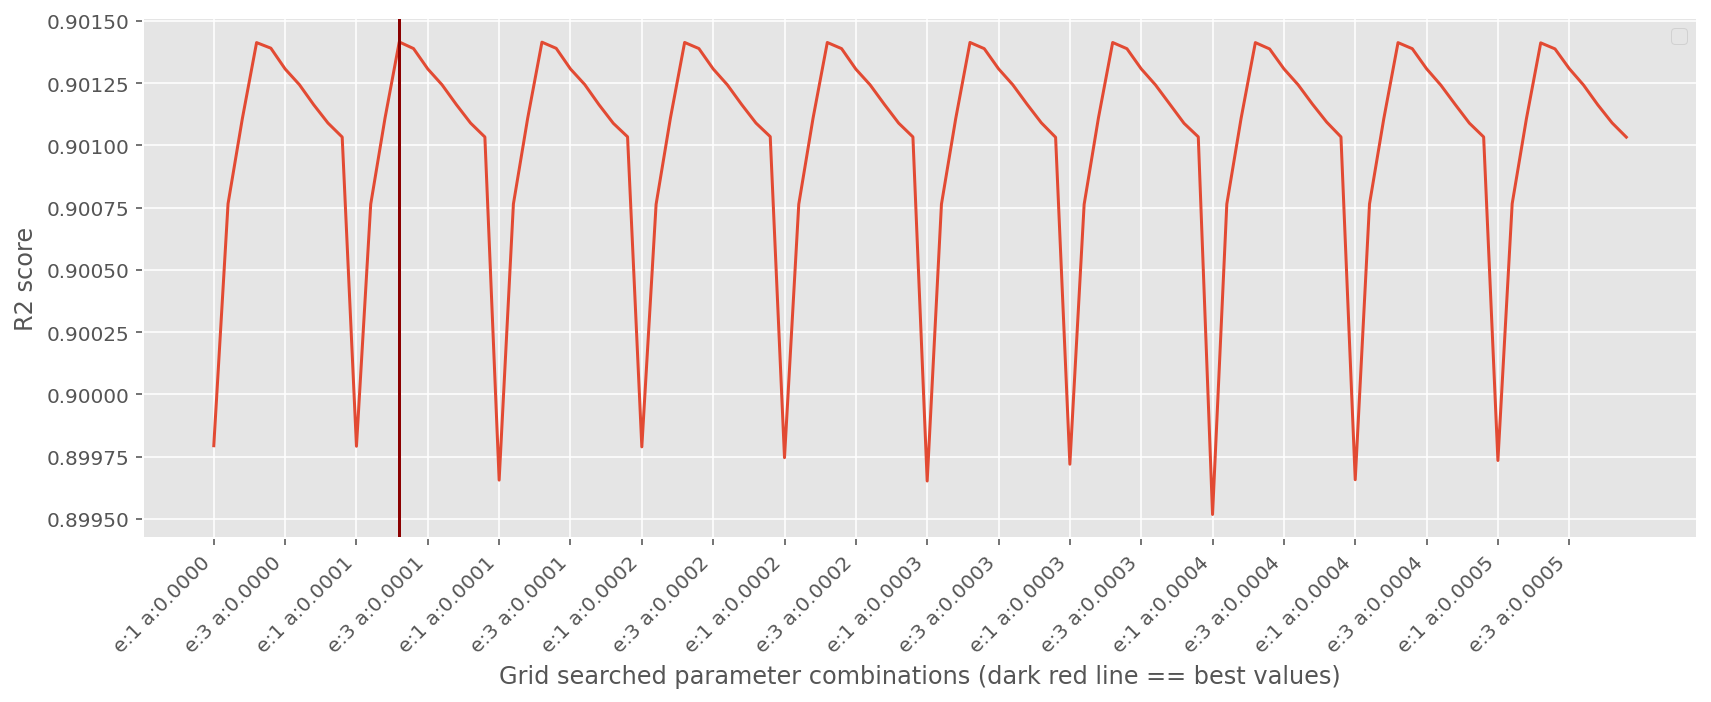

In [51]:
alpha_range = np.linspace(0.000005, 0.0005, 10)
eps_range = np.linspace(1, 5, 10)
best_alpha, best_eps, _ = gridsearch_huber(X_, y, alpha_range, eps_range, cv=10)

#### ⚠️ <span style="color:darkred">Result: The intermediate model has an MAE of 16'304 USD and an R2 score of 0.90.</span>

In [52]:
results_intermediate = do_regression(X_, y, huber_only=True, huber_alpha=best_alpha, huber_epsilon=best_eps, transform_target=True)
display(results_intermediate.style
        .highlight_max(subset=["R2"], color='lightgreen')
        .highlight_min(subset=["MAE"], color='lightgreen')
       )

,MAE,R2
huber,16304,0.902211


Make predictions with intermediate model.

In [53]:
clf_intermediate = get_huber_pipeline(huber_alpha=best_alpha, huber_epsilon=best_eps)
clf_intermediate.fit(X_, y)

# Prepare test data the same way as the training data
X_test = df_test.drop("saleprice", axis=1).copy()
X_test_intermediate = X_test[kbest_cols]

y_pred = clf_intermediate.predict(X_test_intermediate)

df_predictions = df_test.pid.to_frame().copy()
df_predictions.columns = ["PID"]
df_predictions["SalePrice"] = y_pred
df_predictions.reset_index(drop=True, inplace=True)
df_predictions.to_csv("predictions-intermediate-model.csv", index=False)
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PID        500 non-null    int64  
 1   SalePrice  500 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.9 KB


## **(3.) Complex model with all variables**

Gridsearching again for optimal Huber hyperparameters because we now use the full feature set for training.

In [54]:
# alpha_range = np.linspace(0.0001, 0.05, 20)
# alpha_range = [.04]
# eps_range = np.linspace(1, 3, 10)
# best_alpha, best_eps, clf_best = gridsearch_huber(X, y, alpha_range, eps_range)

In [55]:
# Hard coding best hyperparameters to avoid gridsearching over and over again on full notebook runs
best_alpha = 0.04
best_eps = 1.44

#### ⚠️ <span style="color:darkred">Result: The complex model has an MAE of 12'330 USD and an R2 score of 0.94.</span>

In [56]:
results_complex = do_regression(X, y, huber_only=True, huber_alpha=best_alpha, huber_epsilon=best_eps, transform_target=True)
display(results_complex.style
        .highlight_max(subset=["R2"], color='lightgreen')
        .highlight_min(subset=["MAE"], color='lightgreen')
       )

,MAE,R2
huber,12330,0.936452


Make predictions with complex model.

In [57]:
clf_complex = get_huber_pipeline(huber_alpha=best_alpha, huber_epsilon=best_eps)
clf_complex.fit(X, y)

# The test set contains one hot encoded categorical labels that aren't in the training data
# Reduce feature columns to just the ones we have trained our model with
X_test = X_test[X.columns]

y_pred = clf_complex.predict(X_test)

df_predictions = df_test.pid.to_frame().copy()
df_predictions.columns = ["PID"]
df_predictions["SalePrice"] = y_pred
df_predictions.reset_index(drop=True, inplace=True)
df_predictions.to_csv("predictions-complex-model.csv", index=False)
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PID        500 non-null    int64  
 1   SalePrice  500 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.9 KB


# Communicating the results
---


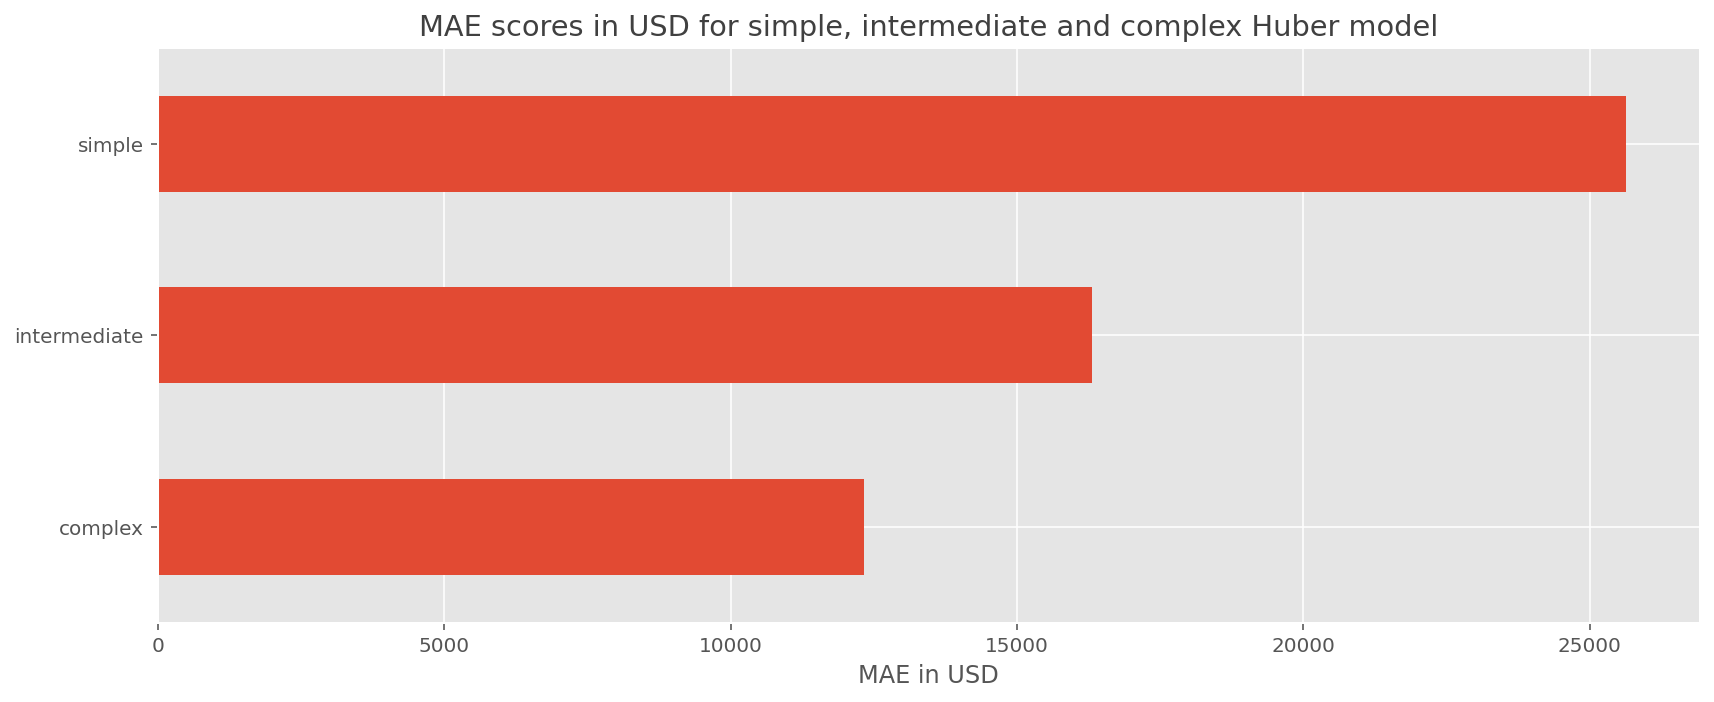

In [58]:
results = pd.concat([pd.DataFrame(results_simple.loc["huber"]).T, results_intermediate, results_complex])
results.index = ["simple", "intermediate", "complex"]
results.MAE.sort_values().plot.barh()
plt.title("MAE scores in USD for simple, intermediate and complex Huber model")
plt.xlabel("MAE in USD")
plt.tight_layout()
plt.show()

## Concluding thoughts
---
- Interesting data set with several hurdles and surprises. 
- **Removing the outliers seemed particularly important to improve scores.** This is interesting since I focussed on the Huber regressor which is more robust towards outliers. 
- **Transforming the target variable `SalePrice` to a more normal distribution led to much better scores as well.**
- **Gridsearching optimal hyperparameters was quite time consuming** especially for the complex model. 
- I **didn't notice substantial improvements through feature engineering.** Almost none of my trials yielded better results.
- I would have gotten the best results with a model of about 110 features as selected by `SelectKBest` (MAE 12k, R2 0.94).